In [1]:
#importing Libraries
import os
import time
import random
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from icecream import ic
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from sklearn.cluster import KMeans
from scipy.stats import spearmanr
from sklearn.impute import KNNImputer
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from dateutil.relativedelta import relativedelta
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from pandarallel import pandarallel
# initialization
pandarallel.initialize()
from dhs_modelling_functions_new import final_ds_droping_cols, fold_generator
from IPython.display import display, HTML

2025-05-29 23:23:29.217384: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


INFO: Pandarallel will run on 24 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [2]:
#setting up random seeds for reproducibility
tf.random.set_seed(6688)
random.seed(6688)
np.random.seed(6688)

In [3]:
input_dir= "/home/myuser/data/preprocessed_data/DHS_n_more/"

min_version = 3
overwrite_pqt = True
dataset_type = 'HR' 
urban_rural_all_mode = 'all'
group_by_col = 'adm2_gaul'

# Scale options
scale_numerical_data = False
scale_all_data = True
leave_out_encodings = True
zero_one_scale_categorical = False
scale_labels = True

# More Options
drop_agriculture = False

in_f = f"{input_dir}5_grouped_df_V3_{dataset_type}_{group_by_col}_joined_with_ipc_{urban_rural_all_mode}.pkl"

In [4]:
input_df_0 = pd.read_pickle(in_f)

df = final_ds_droping_cols(
        input_df_0,
        drop_meta=True, drop_food_help=True, drop_perc=40,
        retain_month=False, drop_highly_correlated_cols=False, drop_region=True,
        drop_data_sets=['Meta one-hot encoding', 'Meta frequency encoding'],
        use_NAN_amount_and_replace_NANs_in_categorical=False,
        drop_agricultural_cols=drop_agriculture,
        drop_below_version=False, numerical_data=['mean'], retain_adm=False,
        retain_GEID_init=False, verbose=3
    )

drop_cols = [c for c in df.columns if 'FS;' in c and '0-2y' not in c]
df.drop(columns=drop_cols, inplace=True, errors='ignore')
df.drop(columns=['DHS Cat; translator used: not at all', 'DHS Cat; translator used: yes'], inplace=True, errors='ignore')

Dropped Meta one-hot encoding; data: ['Meta one-hot encoding; adm0_gaul: Angola', 'Meta one-hot encoding; adm0_gaul: Benin', 'Meta one-hot encoding; adm0_gaul: Burkina Faso', 'Meta one-hot encoding; adm0_gaul: Burundi', 'Meta one-hot encoding; adm0_gaul: Cameroon', 'Meta one-hot encoding; adm0_gaul: Central African Republic', 'Meta one-hot encoding; adm0_gaul: Chad', 'Meta one-hot encoding; adm0_gaul: Comoros', "Meta one-hot encoding; adm0_gaul: Côte d'Ivoire", 'Meta one-hot encoding; adm0_gaul: Democratic Republic of the Congo', 'Meta one-hot encoding; adm0_gaul: Egypt', 'Meta one-hot encoding; adm0_gaul: Ethiopia', 'Meta one-hot encoding; adm0_gaul: Gabon', 'Meta one-hot encoding; adm0_gaul: Gambia', 'Meta one-hot encoding; adm0_gaul: Ghana', 'Meta one-hot encoding; adm0_gaul: Guinea', 'Meta one-hot encoding; adm0_gaul: Kenya', 'Meta one-hot encoding; adm0_gaul: Lesotho', 'Meta one-hot encoding; adm0_gaul: Liberia', 'Meta one-hot encoding; adm0_gaul: Madagascar', 'Meta one-hot encodi

In [5]:
pd.set_option('display.max_rows', 500)

# Dataset Overview

In [6]:
# a summary for each column
def generate_dataset_overview(df):
    overview = pd.DataFrame({
        'Column': df.columns,
        'Data Type': df.dtypes.astype(str),
        'Missing %': (df.isnull().mean() * 100).round(2),
        'Unique Values': df.nunique(),
        'Example Values': df.apply(lambda col: ', '.join(map(str, col.dropna().unique()[:3])))
    })
    return overview

# apply the function
dataset_overview = generate_dataset_overview(df)

# saving to Excel
dataset_overview.to_excel("dhs_dataset_overview.xlsx", index=False)

In [7]:
unique_survey_count = df['Meta; GEID_init'].nunique()
print("Number of unique surveys:", unique_survey_count)

Number of unique surveys: 155


In [8]:
# only keeping: numerical_only and it has missisng values
numerical_only = df.select_dtypes(include=[np.number])

# Per Country Missingness Analysis

In [9]:
country_col = 'Meta; adm0_gaul'
survey_col  = 'Meta; GEID_init'

# counting unique surveys per country
survey_counts = (df.groupby(country_col)[survey_col].nunique().reset_index(name='Num_Surveys'))

# computing per-survey average missingness
survey_missing = (df.groupby([country_col, survey_col]).apply(lambda x: x.isna().mean().mean()).reset_index(name='Survey_Missingness'))

# aggregating to per-country stats
country_stats = (survey_missing.groupby(country_col).agg(Avg_Survey_Missing  = ('Survey_Missingness','mean'),HighMissing_Surveys = ('Survey_Missingness', lambda x: (x > 0.2).sum())).reset_index())

# list of surveys per country (concatenated as strings)
survey_names = (
    df
    .groupby(country_col)[survey_col]
    .apply(lambda x: ', '.join(sorted(x.dropna().unique())))
    .reset_index(name='Survey_Names')
)

# merging everything
summary = (
    survey_counts
    .merge(country_stats, on=country_col)
    .merge(survey_names, on=country_col)
)

# percentage of high-missing surveys
summary['HighMissing_%'] = (summary['HighMissing_Surveys'] / summary['Num_Surveys'] * 100).round(1)

# saving to excel
summary.to_excel('country_survey_missingness_summary_all_countries.xlsx', index=False)

print(summary.head())

  Meta; adm0_gaul  Num_Surveys  Avg_Survey_Missing  HighMissing_Surveys  \
0          Angola            3            0.236943                    2   
1           Benin            4            0.191395                    2   
2    Burkina Faso            6            0.207568                    2   
3         Burundi            3            0.085705                    1   
4        Cameroon            4            0.138306                    1   

                                        Survey_Names  HighMissing_%  
0                       AOGE52FL, AOGE61FL, AOGE71FL           66.7  
1             BJGE33FL, BJGE42FL, BJGE61FL, BJGE71FL           50.0  
2  BFGE32FL, BFGE43FL, BFGE61FL, BFGE71FL, BFGE7A...           33.3  
3                       BUGE61FL, BUGE6AFL, BUGE71FL           33.3  
4             CMGE42FL, CMGE61FL, CMGE71FL, CMGE81FL           25.0  


/tmp/ipykernel_1635876/4227645730.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  survey_missing = (df.groupby([country_col, survey_col]).apply(lambda x: x.isna().mean().mean()).reset_index(name='Survey_Missingness'))


# Three specific countries will be removed from dataset to retain Data Quality

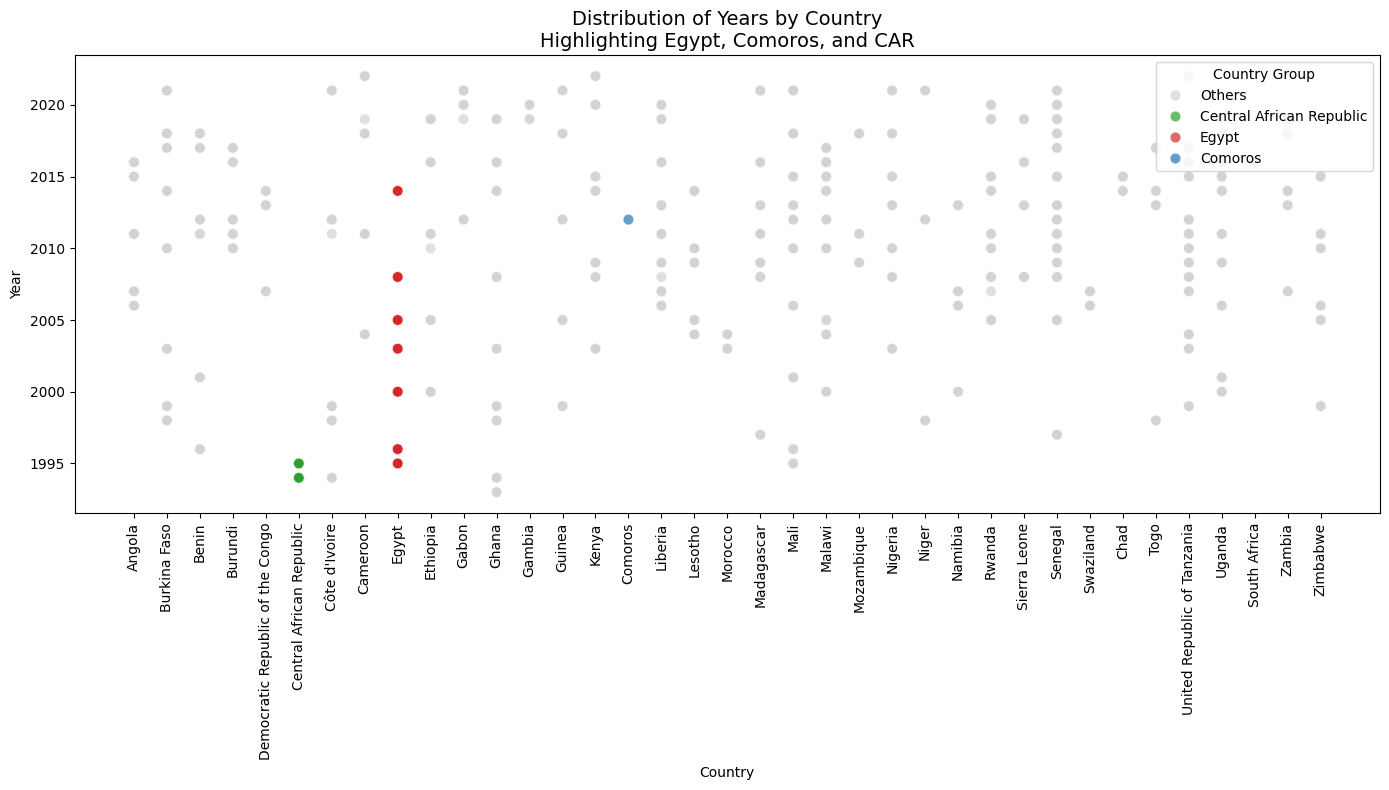

In [10]:
# identifying year column
year_col = 'Meta; year' if 'Meta; year' in df.columns else 'year'

# the three problematic countries
drops = ['Egypt', 'Comoros', 'Central African Republic']

# group rows into 'Egypt', 'Comoros', 'CAR', and 'Others'
df['Group'] = df['Meta; adm0_gaul'].apply(lambda c: c if c in drops else 'Others')

# a frequency plot: countries (X), year (Y), colored by group
plt.figure(figsize=(14, 8))
sns.scatterplot(
    data=df,
    x='Meta; adm0_gaul',
    y=year_col,
    hue='Group',
    palette={
        'Egypt': '#D62728',
        'Comoros': '#1f77b4',
        'Central African Republic': '#2ca02c',
        'Others': 'lightgray'
    },
    alpha=0.7,
    s=60
)
plt.xticks(rotation=90)
plt.xlabel("Country")
plt.ylabel("Year")
plt.title("Distribution of Years by Country\nHighlighting Egypt, Comoros, and CAR", fontsize=14)
plt.legend(title="Country Group", loc='upper right')
plt.tight_layout()
plt.show()

# Generating a missingness heatmap where -
### 1. X-axis: Countries/surveys
### 2. Y-axis: Variables
### 3. Color intensity: Proportion of missing data
This visual representation will quickly highlight patterns across countries and variables.

# by country with unique columns

/tmp/ipykernel_1635876/4143559857.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  missing_data_country = unique_df.groupby('Meta; adm0_gaul').apply(lambda x: x.isnull().mean())


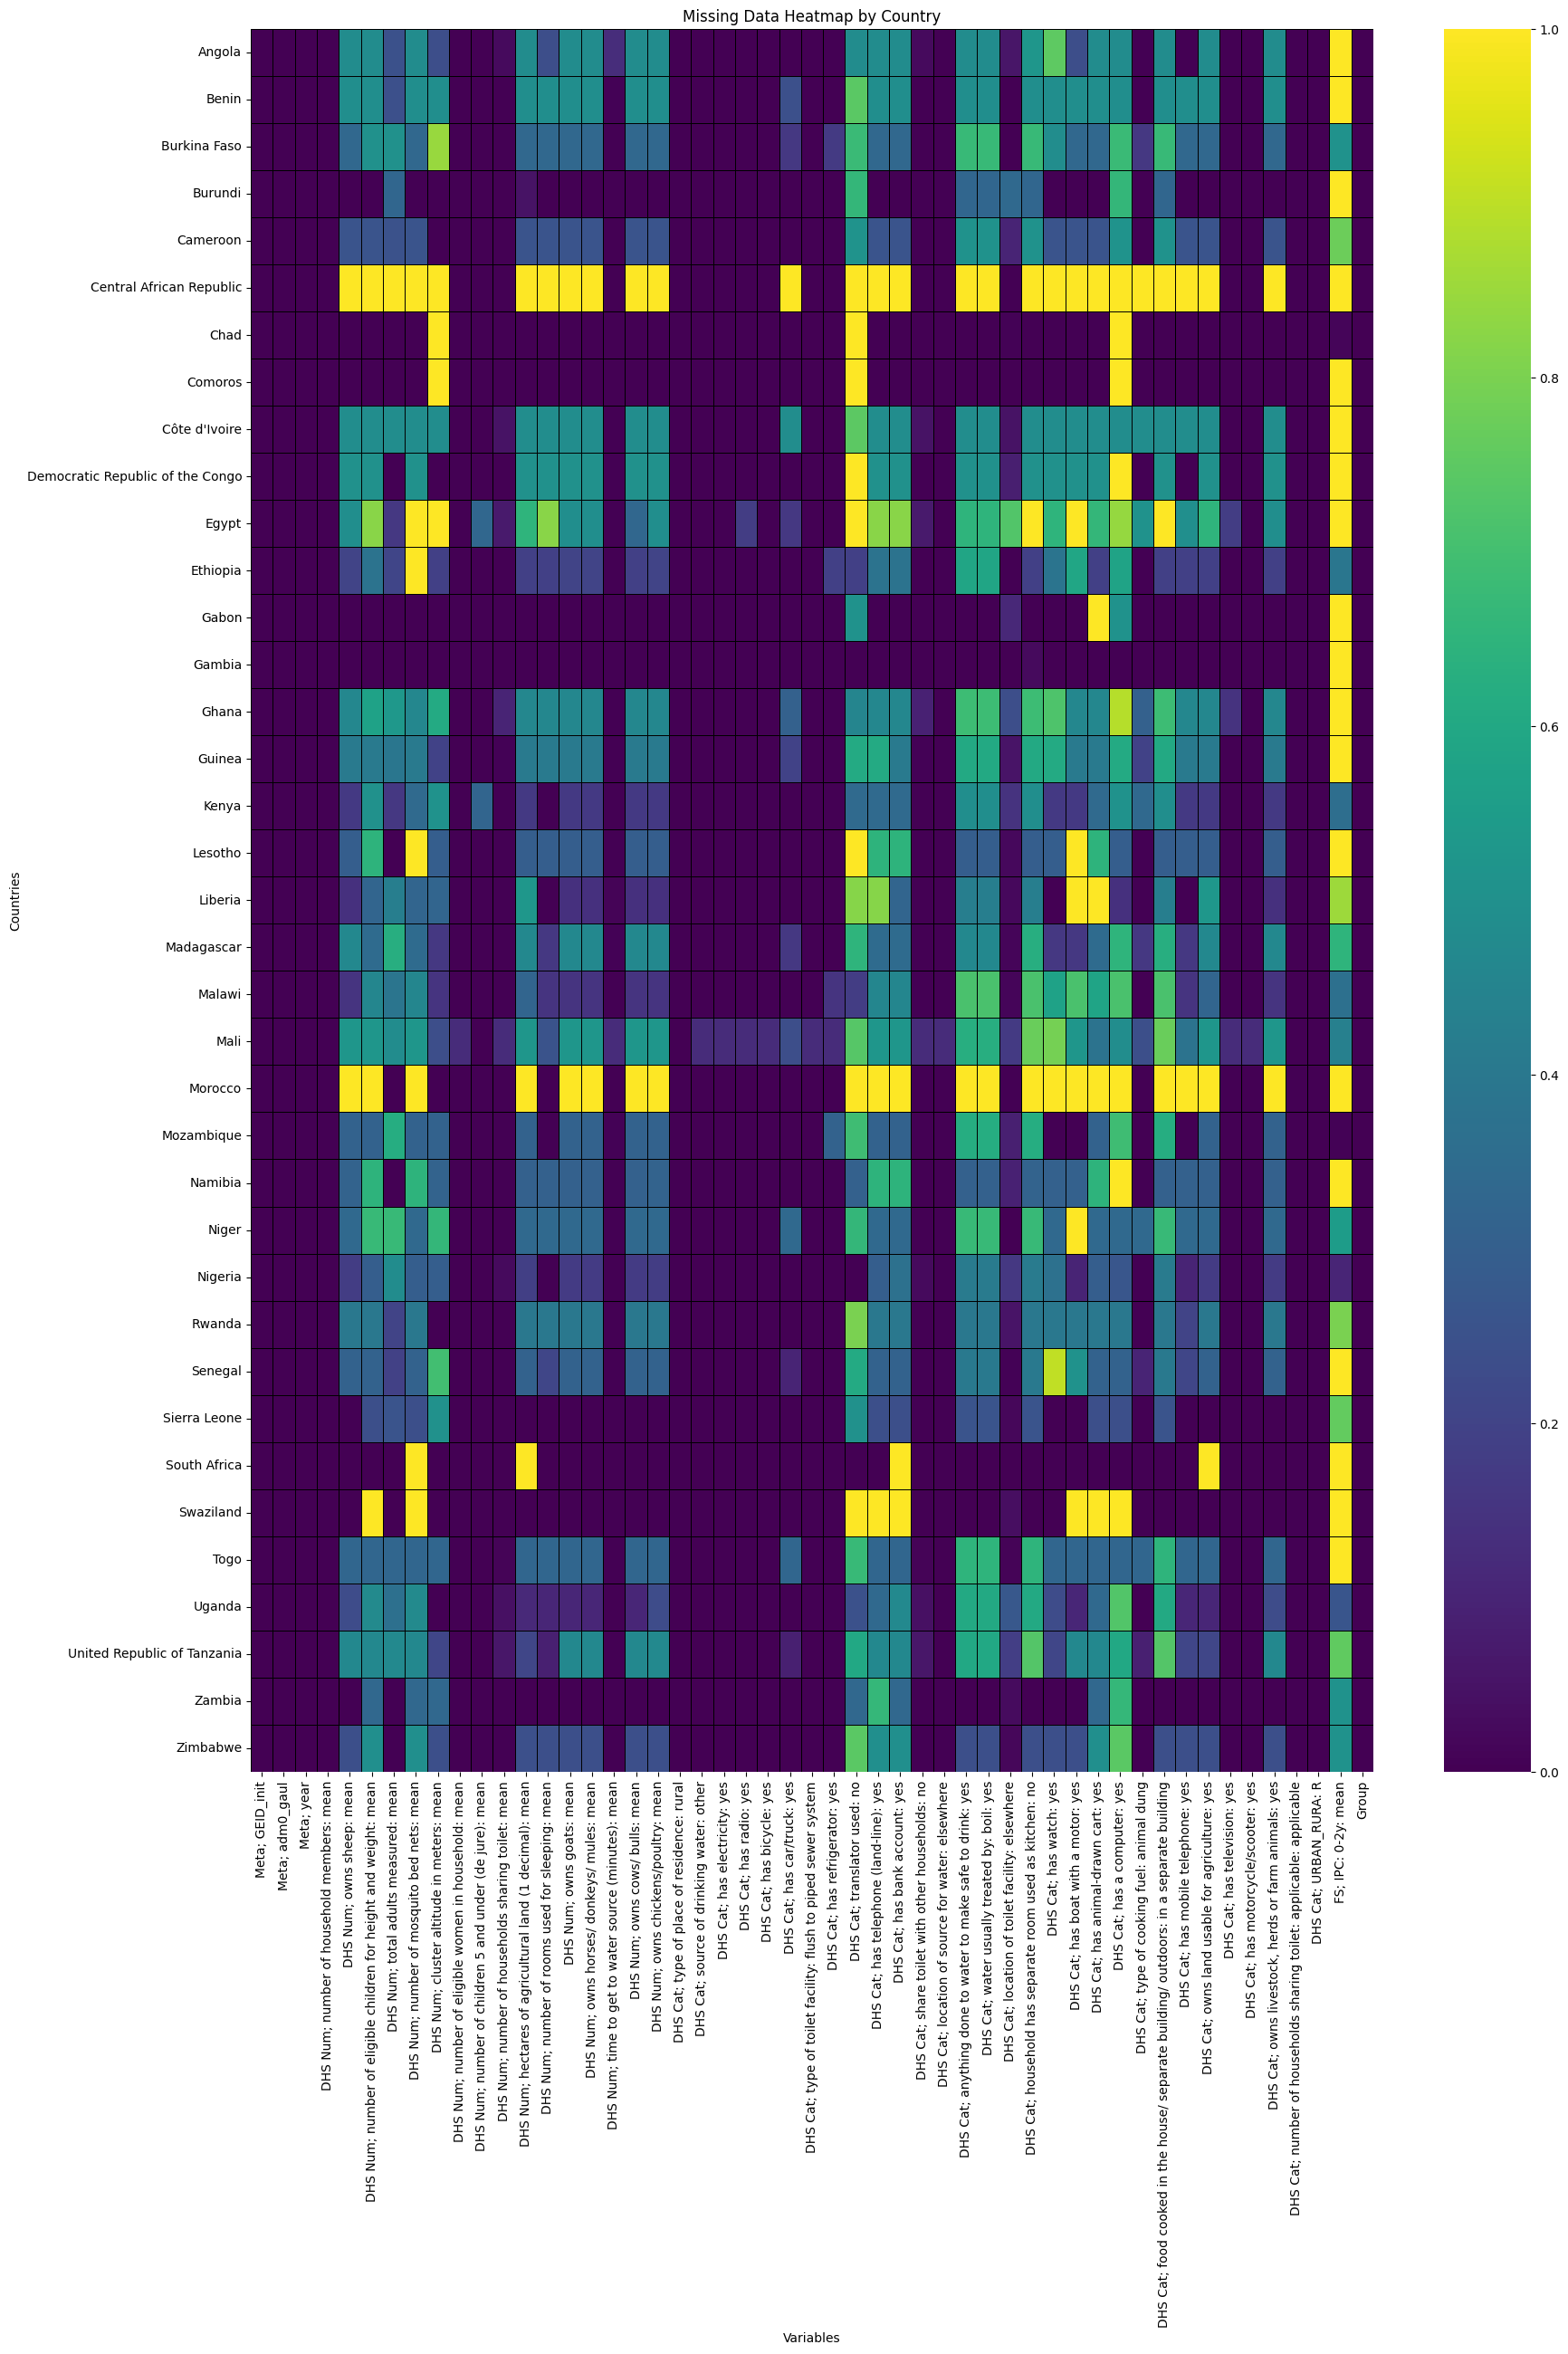

In [11]:
# extracting the initial part of each column name
initial_columns = df.columns.str.extract(r'(^[^:]+)', expand=False)

# a mask to keep only the first occurrence of each initial part
unique_columns_mask = ~initial_columns.duplicated()

# the mask to keep only unique initial columns
unique_df = df.loc[:, unique_columns_mask]

# the proportion of missing data per country for the filtered columns
missing_data_country = unique_df.groupby('Meta; adm0_gaul').apply(lambda x: x.isnull().mean())

# the heatmap 
plt.figure(figsize=(20, 25))  
sns.heatmap(missing_data_country, cbar=True, cmap='viridis', yticklabels=True, linewidths=0.5, linecolor='black')
plt.xlabel('Variables')
plt.ylabel('Countries')
plt.title('Missing Data Heatmap by Country')
plt.xticks(rotation=90)  
plt.yticks(rotation=0)  
plt.show()

# by country without unique columns

/tmp/ipykernel_1635876/3251950428.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  missing_data_country = df.groupby('Meta; adm0_gaul').apply(lambda x: x.isnull().mean())


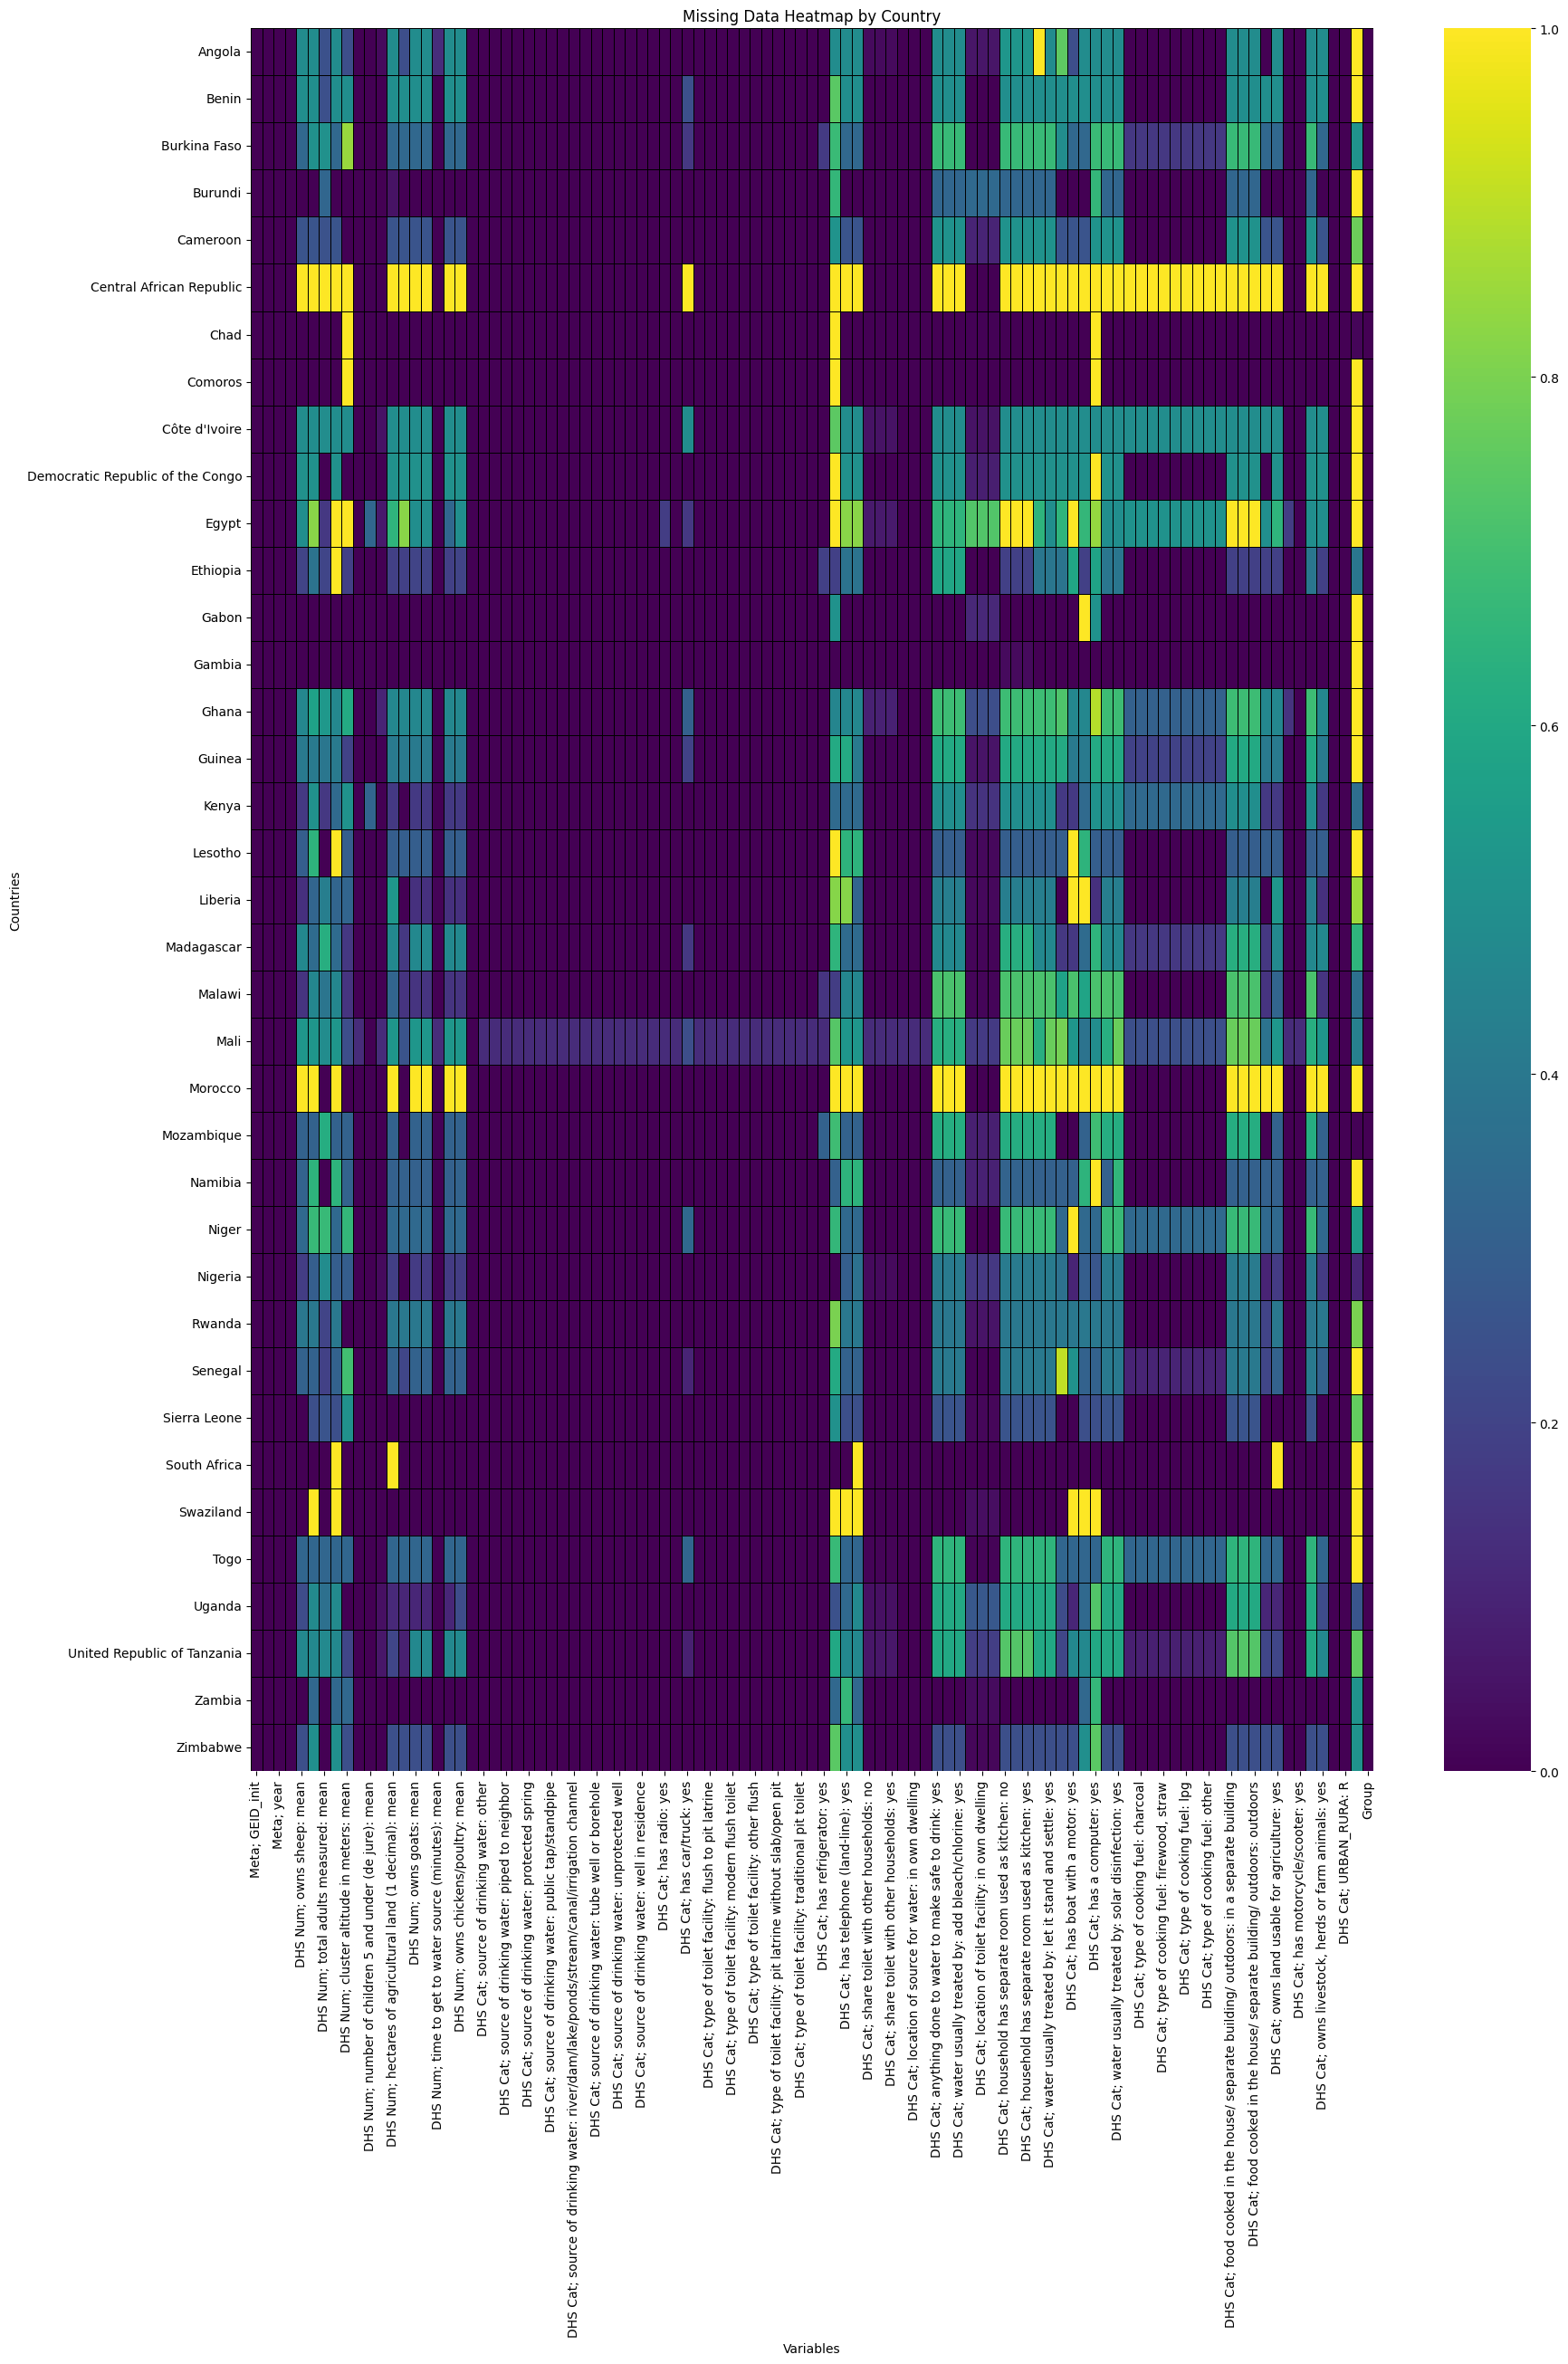

In [12]:
#the proportion of missing data per country
missing_data_country = df.groupby('Meta; adm0_gaul').apply(lambda x: x.isnull().mean())

plt.figure(figsize=(20, 25))  
sns.heatmap(missing_data_country, cbar=True, cmap='viridis', yticklabels=True, linecolor='black', linewidths=0.5)
plt.xlabel('Variables')
plt.ylabel('Countries')
plt.title('Missing Data Heatmap by Country')
plt.xticks(rotation=90) 
plt.yticks(rotation=0)  
plt.show()

# by survey with unique columns

/tmp/ipykernel_1635876/3791713448.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  missing_data_survey = unique_df.groupby('Meta; GEID_init').apply(lambda x: x.isnull().mean())


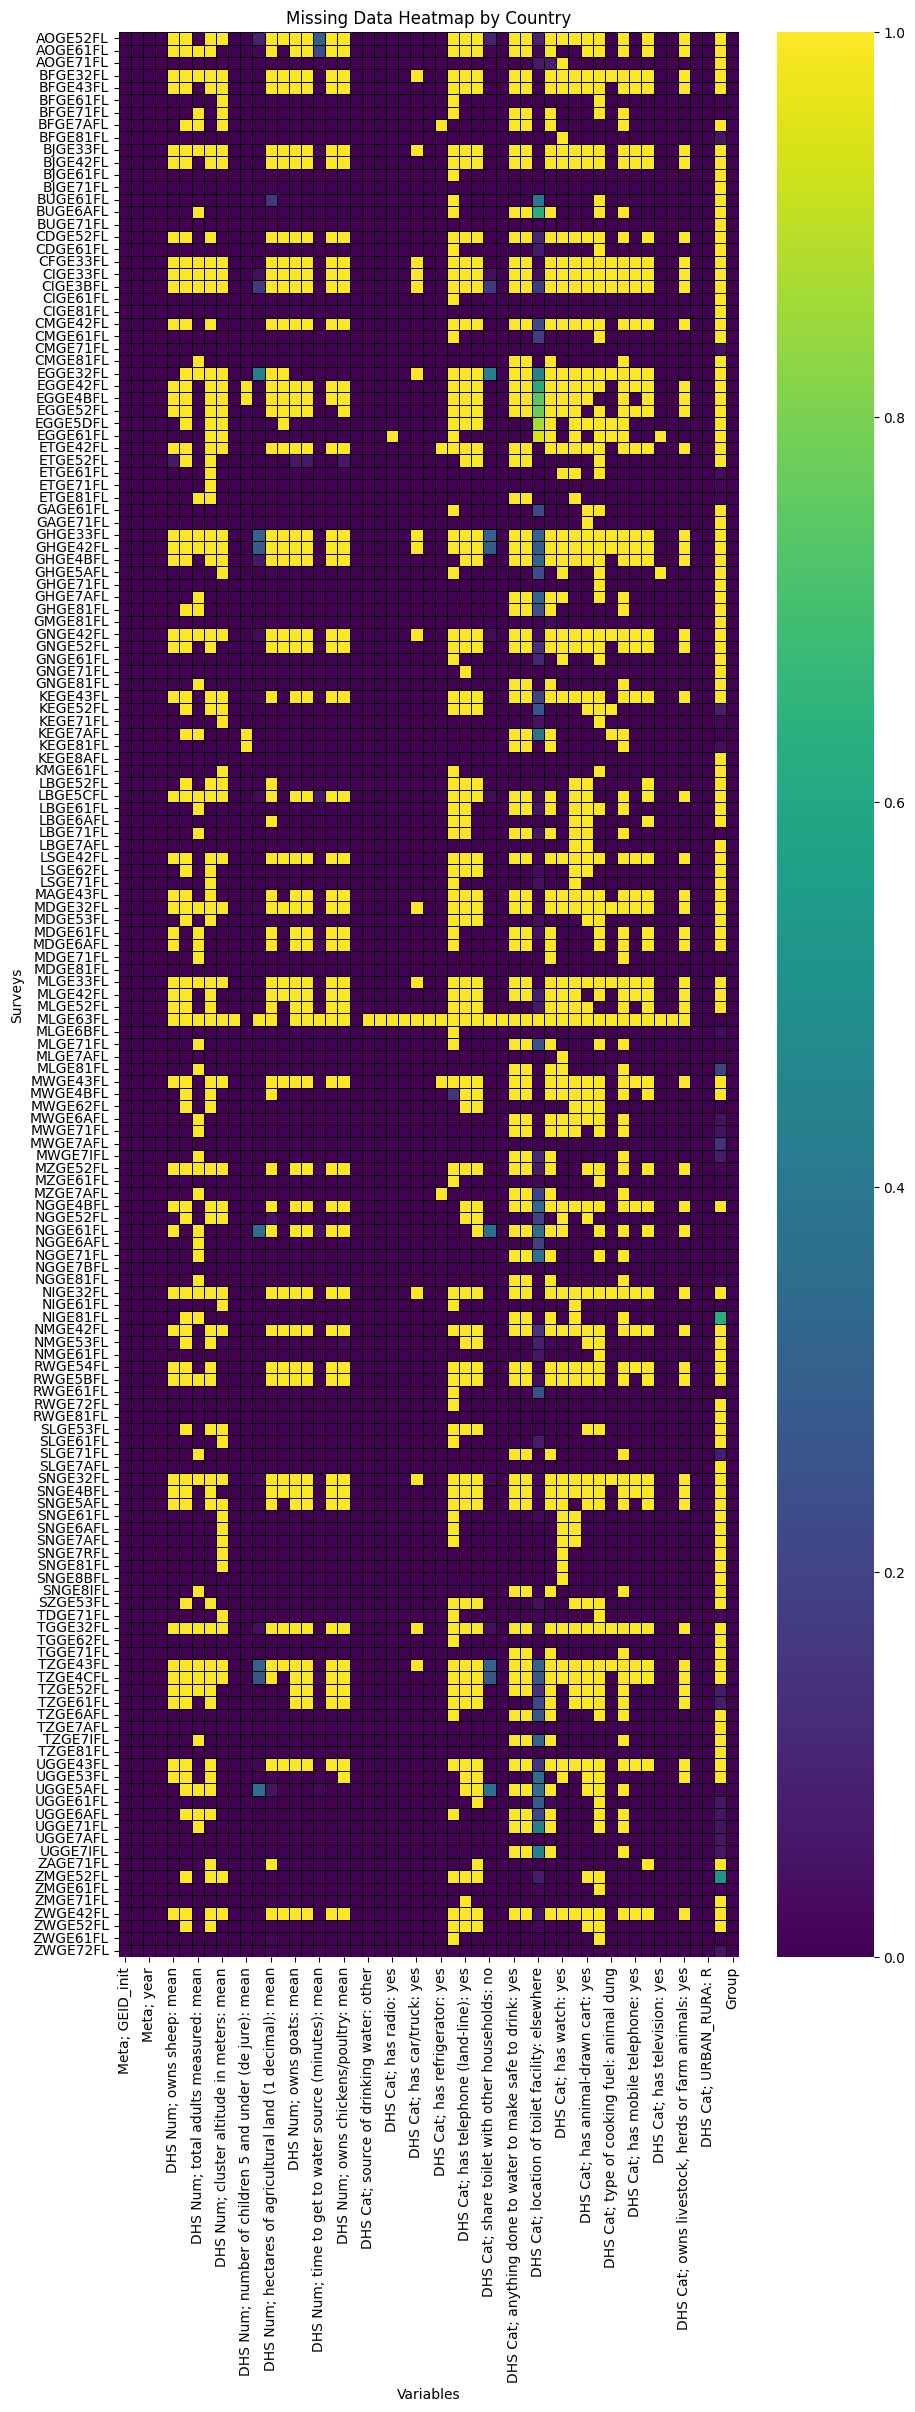

In [13]:
#the proportion of missing data per country
missing_data_survey = unique_df.groupby('Meta; GEID_init').apply(lambda x: x.isnull().mean())

plt.figure(figsize=(10, 25))  
sns.heatmap(missing_data_survey, cbar=True, cmap='viridis', yticklabels=True, linecolor='black', linewidths=0.5)
plt.xlabel('Variables')
plt.ylabel('Surveys')
plt.title('Missing Data Heatmap by Country')
plt.xticks(rotation=90) 
plt.yticks(rotation=0)  
plt.show()

# by year with unique columns

/tmp/ipykernel_1635876/1049653880.py:17: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  missing_data_yr = filtered_df.groupby('Meta; year').apply(lambda x: x.isnull().mean())


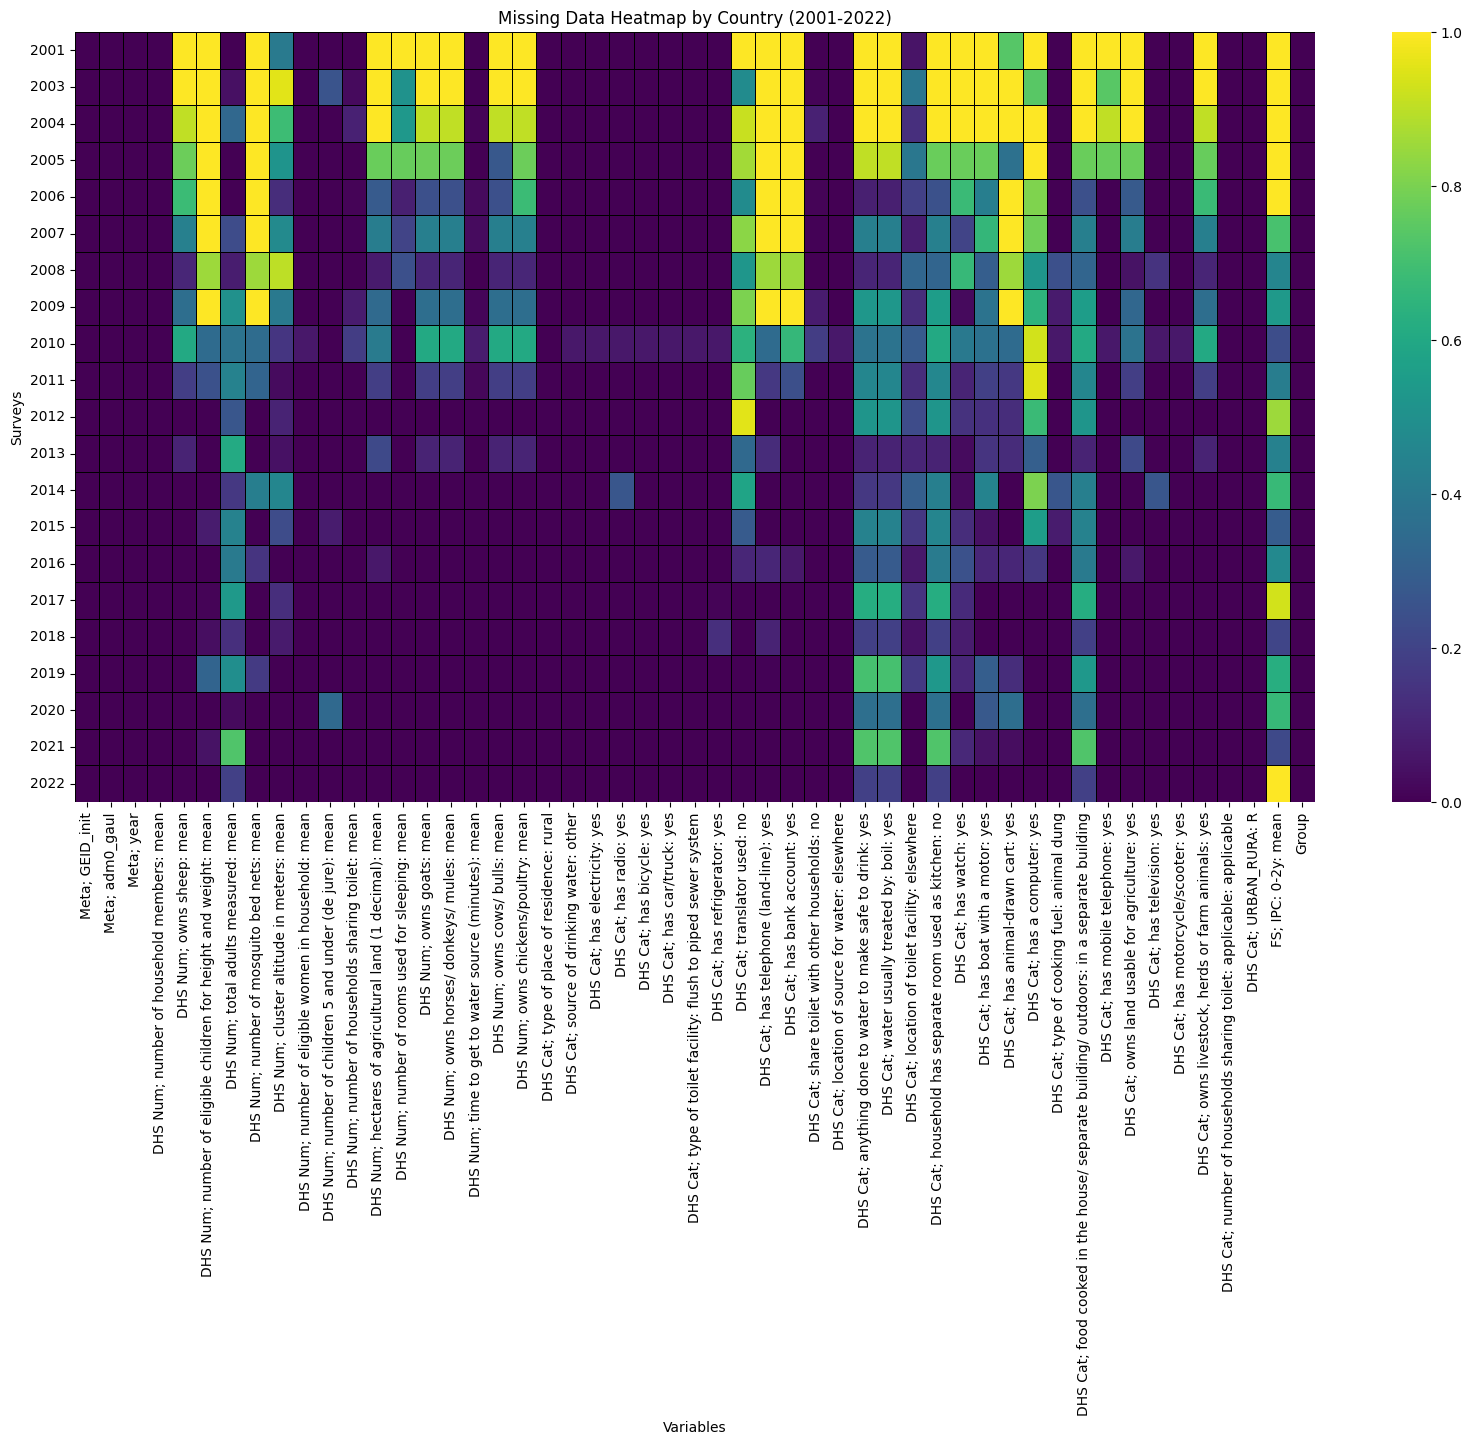

In [14]:
# #the proportion of missing data per country
# missing_data_yr = unique_df.groupby('Meta; year').apply(lambda x: x.isnull().mean())

# plt.figure(figsize=(10, 20))  
# sns.heatmap(missing_data_yr, cbar=True, cmap='viridis', yticklabels=True, linecolor='black', linewidths=0.5)
# plt.xlabel('Variables')
# plt.ylabel('Surveys')
# plt.title('Missing Data Heatmap by Country')
# plt.xticks(rotation=90) 
# plt.yticks(rotation=0)  
# plt.show()

# Filter the data to include only the years between 2006 and 2022
filtered_df = unique_df[(unique_df['Meta; year'] >= 2001) & (unique_df['Meta; year'] <= 2022)]

# Calculate the proportion of missing data per year
missing_data_yr = filtered_df.groupby('Meta; year').apply(lambda x: x.isnull().mean())

# Plotting the heatmap
plt.figure(figsize=(20, 10))
sns.heatmap(missing_data_yr, cbar=True, cmap='viridis', yticklabels=True, linecolor='black', linewidths=0.5)
plt.xlabel('Variables')
plt.ylabel('Surveys')
plt.title('Missing Data Heatmap by Country (2001-2022)')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()

# Quantitative Analysis:
### a) Calculate the missingness proportions:
#### 1. For each country-variable combination
#### 2. For each variable across all countries
#### 3. For each country across all variables

Missingness proportions for each country-variable combination:

Missingness proportions for each variable across all countries:

Missingness proportions for each country across all variables:


/tmp/ipykernel_1635876/1224147438.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  missingness_per_country = unique_df.groupby('Meta; adm0_gaul').apply(lambda x: x.isnull().mean().mean())


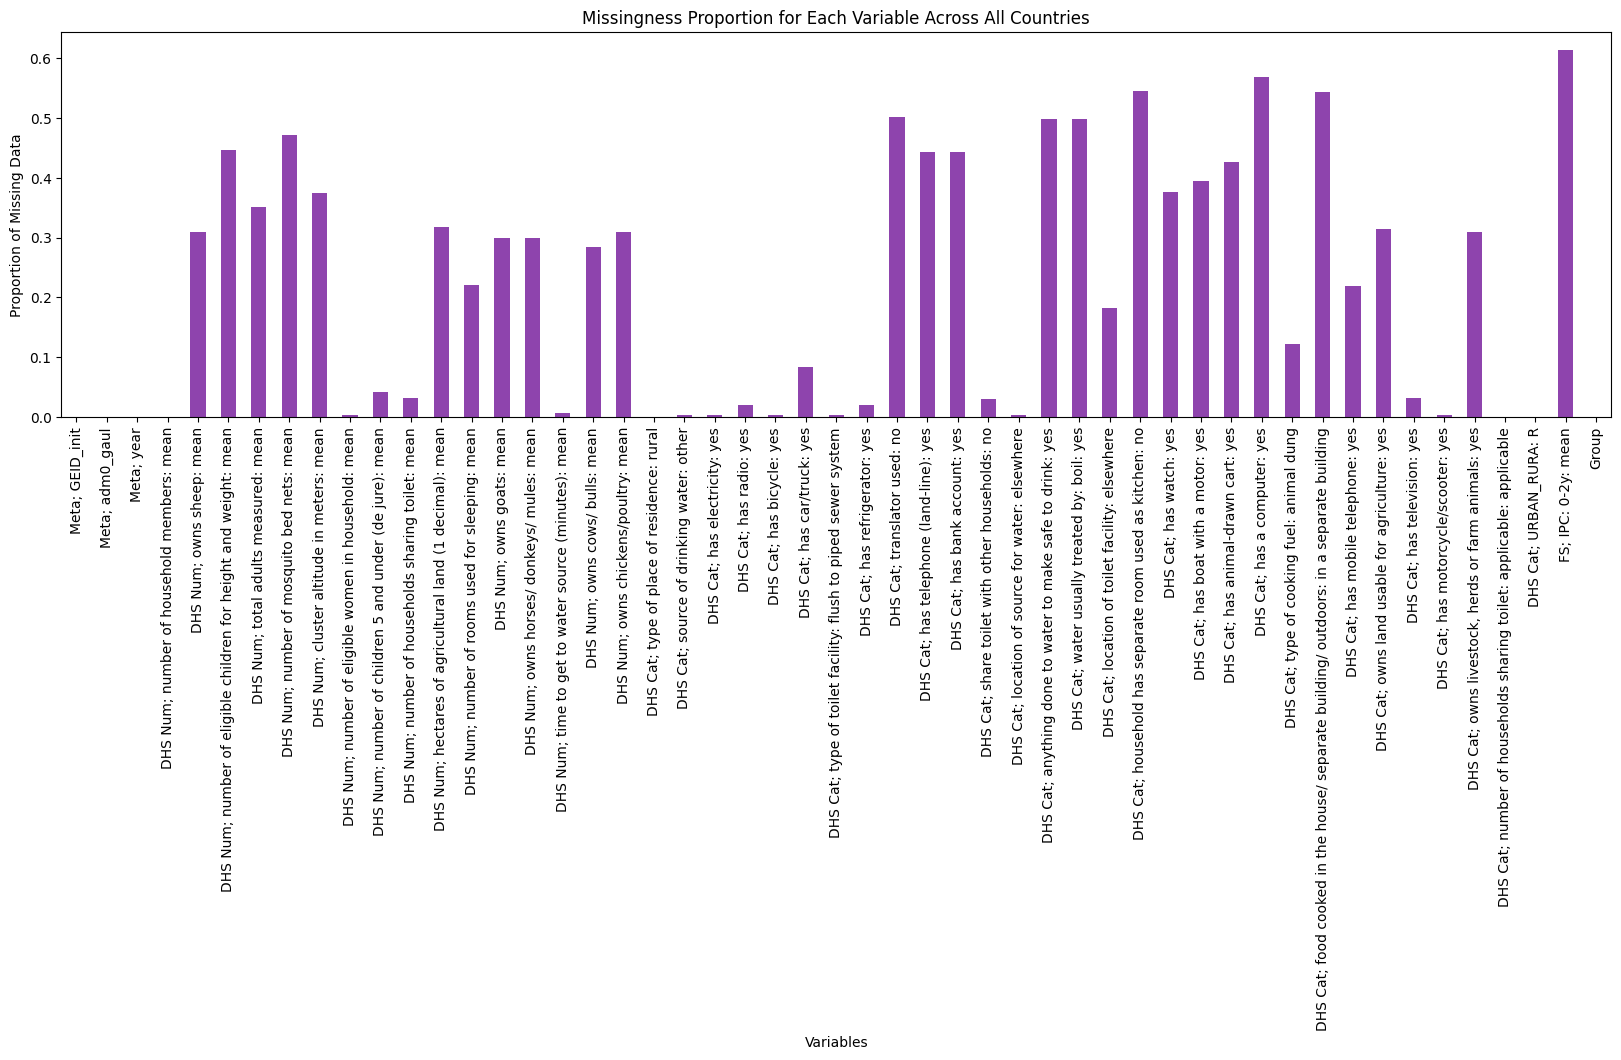

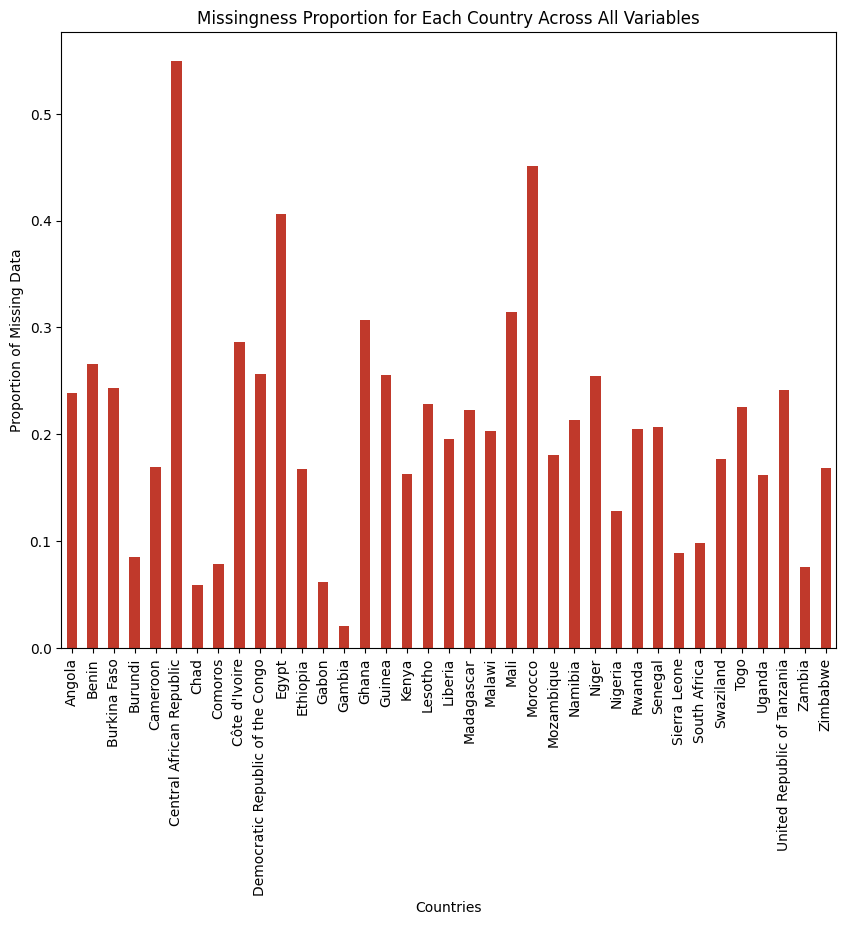

In [15]:
# Quantitative Analysis
# fr each country-variable combination
print("Missingness proportions for each country-variable combination:")
#print(missing_data_country)

# for each variable across all countries
missingness_per_variable = unique_df.isnull().mean()
print("\nMissingness proportions for each variable across all countries:")
#print(missingness_per_variable)

# fr each country across all variables
missingness_per_country = unique_df.groupby('Meta; adm0_gaul').apply(lambda x: x.isnull().mean().mean())
print("\nMissingness proportions for each country across all variables:")
#print(missingness_per_country)

# the missingness proportions for each variable across all countries
plt.figure(figsize=(20, 5))
missingness_per_variable.plot(kind='bar', color='#8e44ad')
plt.xlabel('Variables')
plt.ylabel('Proportion of Missing Data')
plt.title('Missingness Proportion for Each Variable Across All Countries')
plt.xticks(rotation=90)
plt.show()

# the missingness proportions for each country across all variables
plt.figure(figsize=(10, 8))
missingness_per_country.plot(kind='bar', color='#c0392b')
plt.xlabel('Countries')
plt.ylabel('Proportion of Missing Data')
plt.title('Missingness Proportion for Each Country Across All Variables')
plt.xticks(rotation=90)
plt.show()

# survey

Missingness proportions for each survey-variable combination:

Missingness proportions for each variable across all surveys:

Missingness proportions for each survey across all variables:


/tmp/ipykernel_1635876/4251772152.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  missingness_per_survey = unique_df.groupby('Meta; GEID_init').apply(lambda x: x.isnull().mean().mean())


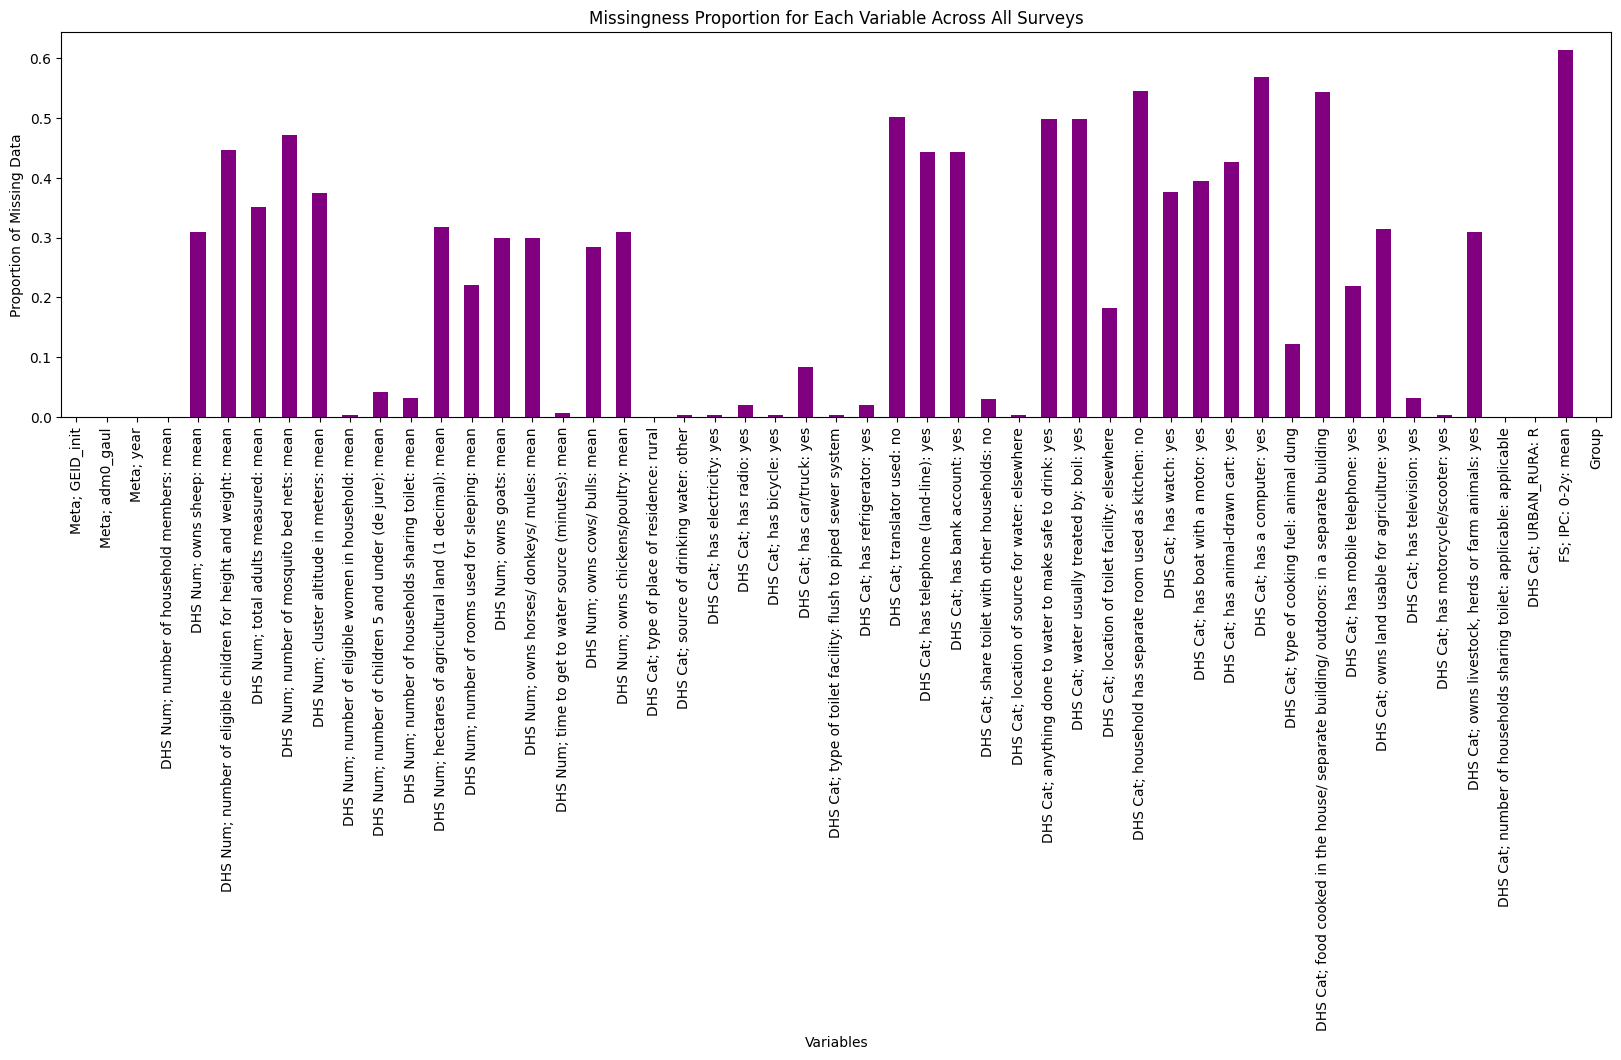

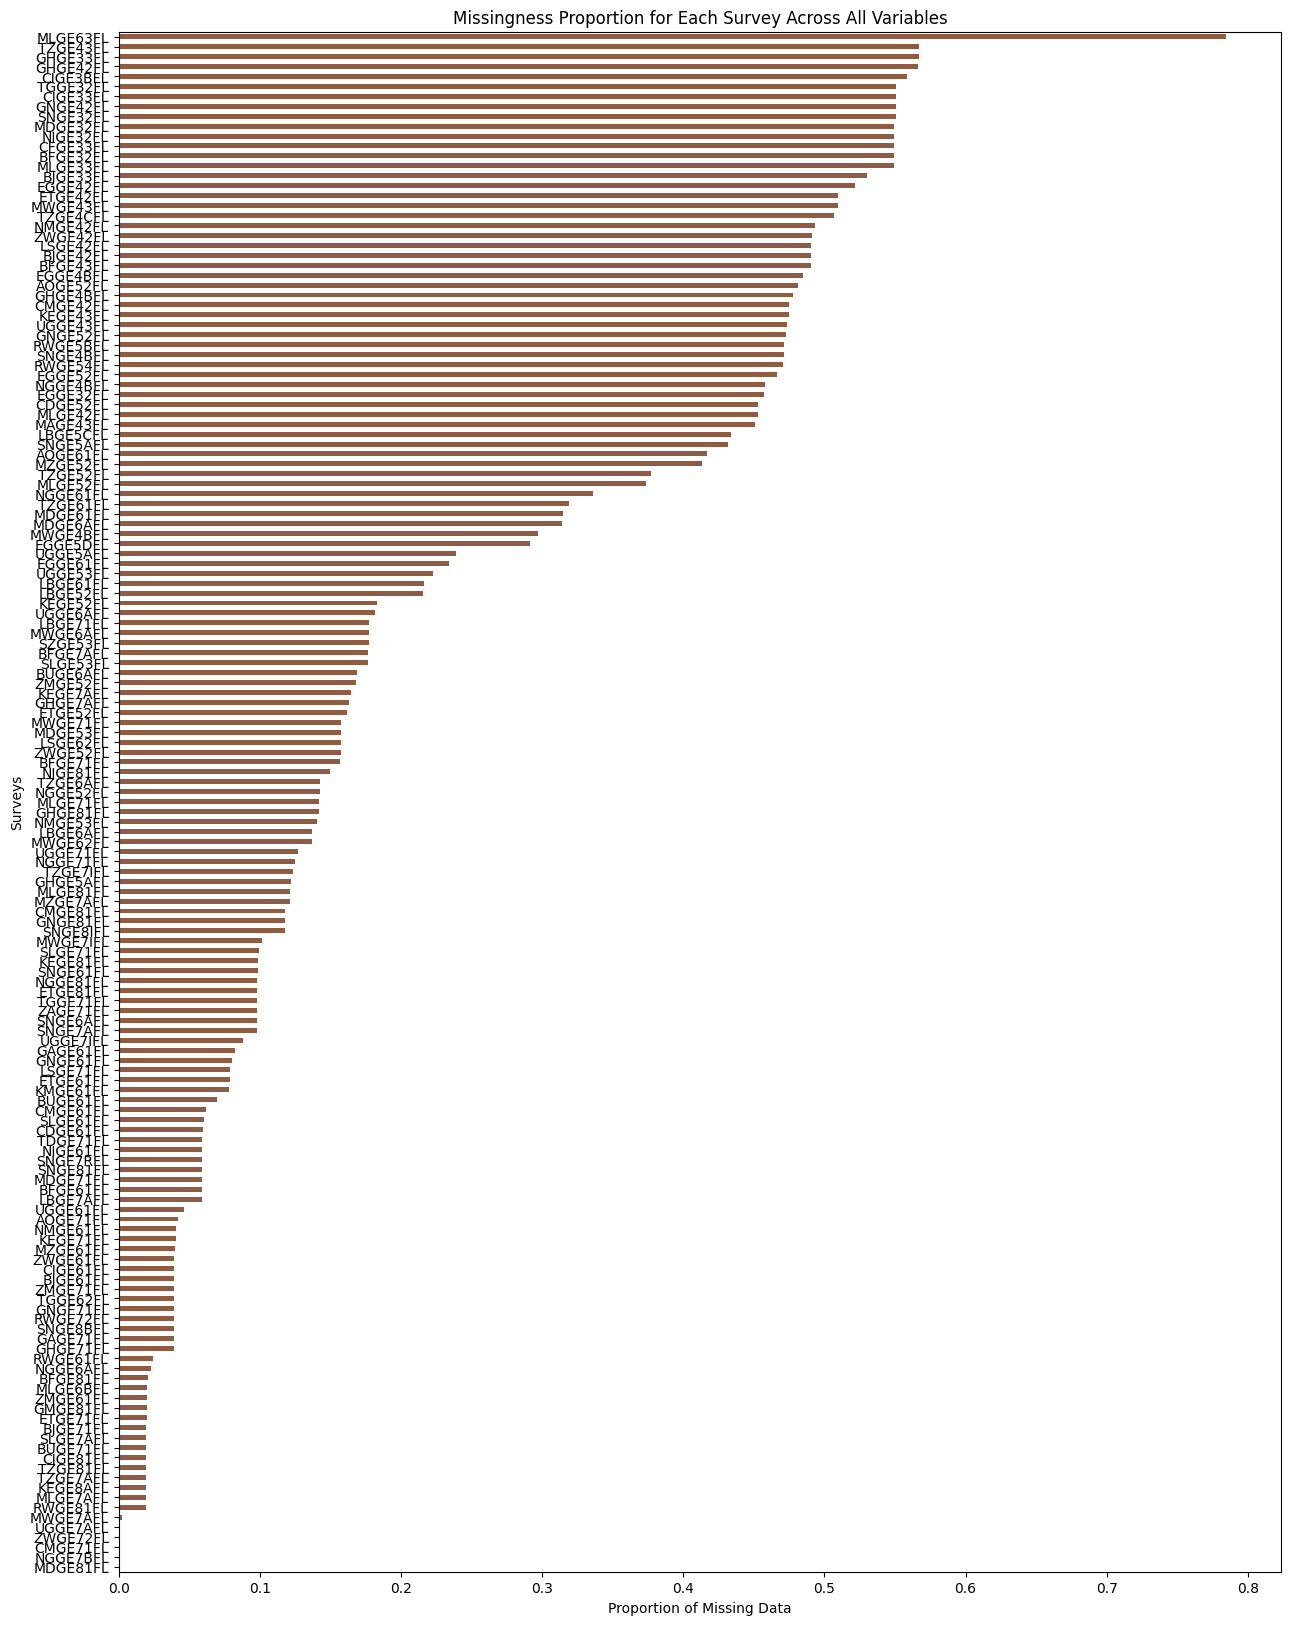

In [16]:
# each survey-variable combination
print("Missingness proportions for each survey-variable combination:")
#print(missing_data_survey)

# each variable across all surveys
missingness_per_variable = unique_df.isnull().mean()
print("\nMissingness proportions for each variable across all surveys:")
#print(missingness_per_variable)

# each survey across all variables
missingness_per_survey = unique_df.groupby('Meta; GEID_init').apply(lambda x: x.isnull().mean().mean())
print("\nMissingness proportions for each survey across all variables:")
#print(missingness_per_survey)

# the missingness proportions for each variable across all surveys
plt.figure(figsize=(20, 5))
missingness_per_variable.plot(kind='bar', color='#800080')
plt.xlabel('Variables')
plt.ylabel('Proportion of Missing Data')
plt.title('Missingness Proportion for Each Variable Across All Surveys')
plt.xticks(rotation=90)
plt.show()

# the missingness proportions for each survey across all variables
plt.figure(figsize=(15, 20))
missingness_per_survey.sort_values().plot(kind='barh', color='#8e5c42')
plt.ylabel('Surveys')
plt.xlabel('Proportion of Missing Data')
plt.title('Missingness Proportion for Each Survey Across All Variables')
plt.show()

# year

Missingness proportions for each year-variable combination:

Missingness proportions for each variable across all years:

Missingness proportions for each year across all variables:


/tmp/ipykernel_1635876/624780673.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  missingness_per_year = unique_df.groupby('Meta; year').apply(lambda x: x.isnull().mean().mean())


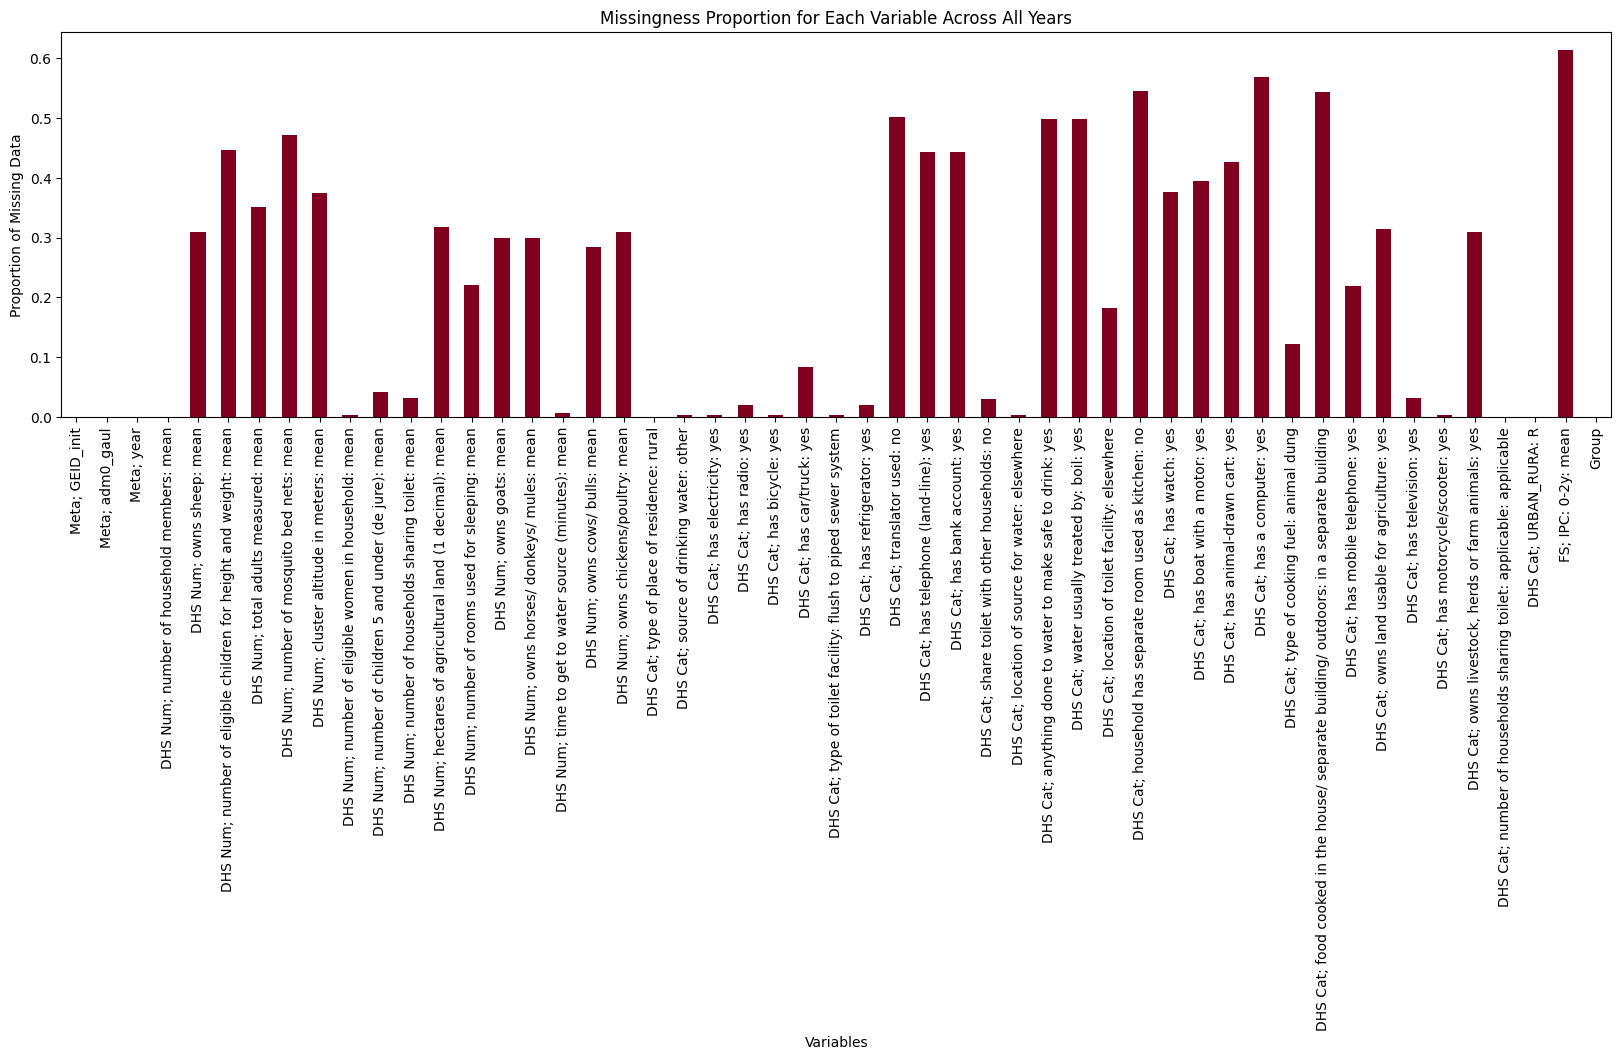

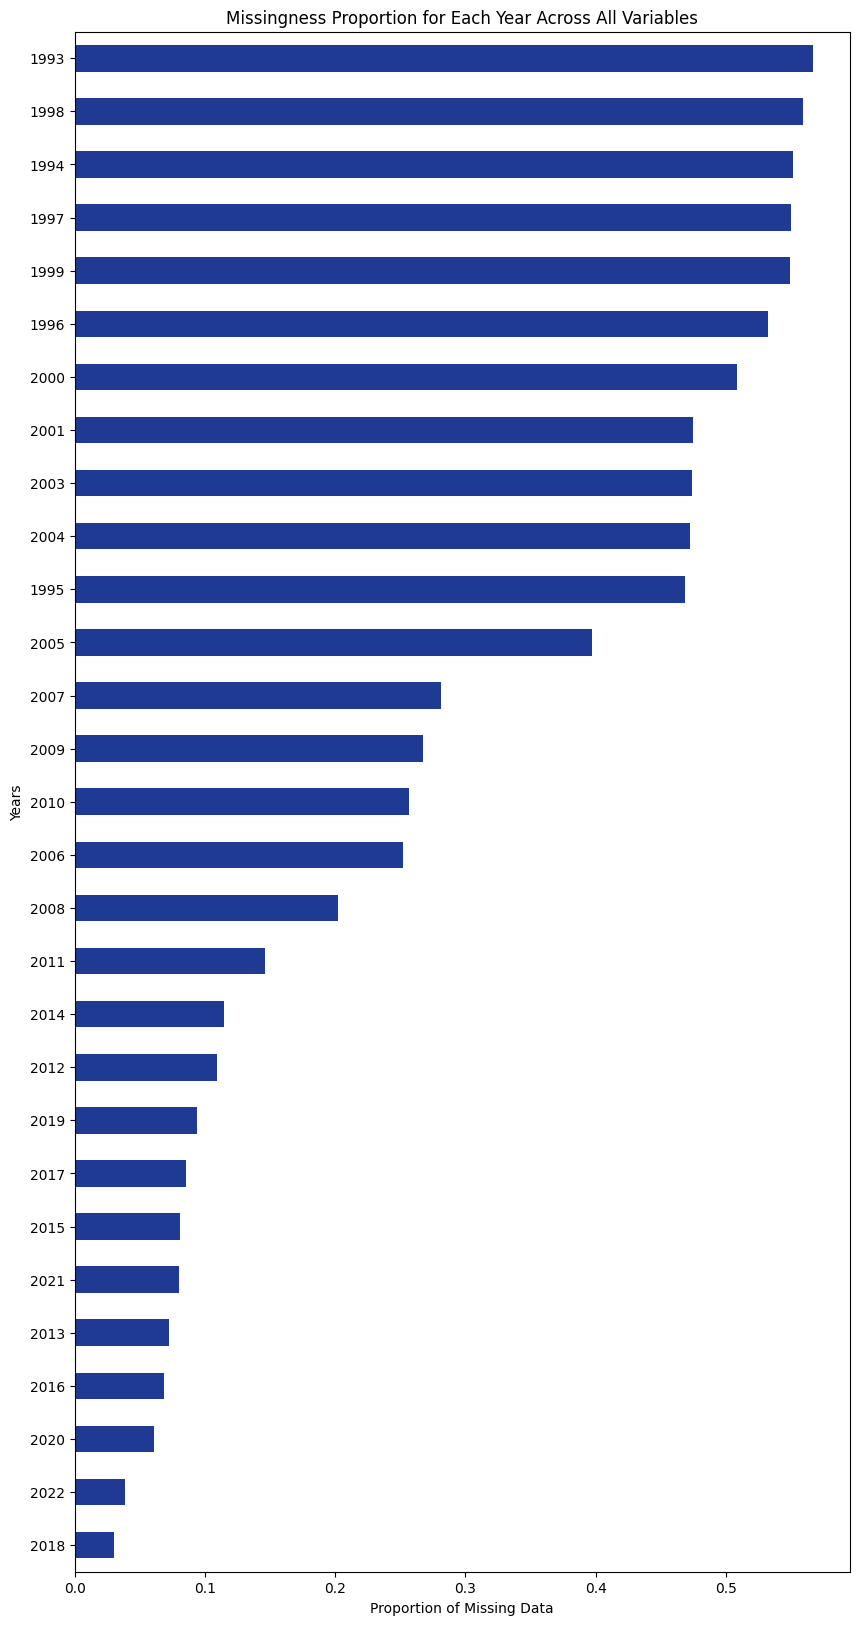

In [17]:
# each year-variable combination
print("Missingness proportions for each year-variable combination:")
#print(missing_data_yr)

# each variable across all years
missingness_per_variable = unique_df.isnull().mean()
print("\nMissingness proportions for each variable across all years:")
#print(missingness_per_variable)

# each year across all variables
missingness_per_year = unique_df.groupby('Meta; year').apply(lambda x: x.isnull().mean().mean())
print("\nMissingness proportions for each year across all variables:")
#print(missingness_per_year)

# the missingness proportions for each variable across all years
plt.figure(figsize=(20, 5))
missingness_per_variable.plot(kind='bar', color='#800020')
plt.xlabel('Variables')
plt.ylabel('Proportion of Missing Data')
plt.title('Missingness Proportion for Each Variable Across All Years')
plt.xticks(rotation=90)
plt.show()

# the missingness proportions for each year across all variables (years on y-axis)
plt.figure(figsize=(10, 20))
missingness_per_year.sort_values().plot(kind='barh', color='#1f3a93')
plt.ylabel('Years')
plt.xlabel('Proportion of Missing Data')
plt.title('Missingness Proportion for Each Year Across All Variables')
plt.show()

# detailed geographic analysis

In [18]:
# assuming unique_df is the df aftr filtering unique initial columns
unique_df = df.loc[:, unique_columns_mask]

# retrieving columns with the specific prefixes
meta_columns = [col for col in unique_df.columns if col.startswith('Meta;')]
num_columns = [col for col in unique_df.columns if col.startswith('DHS Num;')]
cat_columns = [col for col in unique_df.columns if col.startswith('DHS Cat;')]

# one column from each group of 'DHS Cat;' columns
selected_cat_columns = []
seen_categories = set()

for col in cat_columns:
    category = col.split(';')[1].split(':')[0]
    if category not in seen_categories:
        seen_categories.add(category)
        selected_cat_columns.append(col)

# the final dataset with the selected columns
selected_columns = meta_columns + num_columns + selected_cat_columns
detailed_geographic_df = unique_df[selected_columns]

# the percentage of available data per row
detailed_geographic_df['Available Data %'] = detailed_geographic_df.notnull().mean(axis=1) * 100

# reordering columns 
final_columns_order = meta_columns + ['Available Data %'] + num_columns + selected_cat_columns
detailed_geographic_df = detailed_geographic_df[final_columns_order]

# the resulting df
#display(HTML(detailed_geographic_df.to_html()))

# saving the df to a CSV file
detailed_geographic_df.to_csv('detailed_geographic_analysis.csv', index=False)

/tmp/ipykernel_1635876/575502903.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  detailed_geographic_df['Available Data %'] = detailed_geographic_df.notnull().mean(axis=1) * 100


# To Analyze Correlations

### Data Cleaning

In [19]:
# countries to drop
countries_to_drop = ['Egypt',  'Central African Republic', 'Comoros'] 

# dropping rows where 'Meta; adm0_gaul' is in the drop list
df_filtered = df[~df['Meta; adm0_gaul'].isin(countries_to_drop)]

# new shape
print("New shape after dropping specified countries:", df_filtered.shape)

New shape after dropping specified countries: (13723, 99)


### Only keeping numerical columns which have NaNs by ignoring meta data

In [20]:
# only keeping: numerical_only and it has missisng values!
numerical_only = df_filtered.select_dtypes(include=[np.number])
numerical_only.shape

(13723, 96)

## Initial KNN imputation to fill NaNs to retain most of the dataset size and diversity instead of dropping all NaNs

In [21]:
# applying KNN Imputer
imputer = KNNImputer(n_neighbors=5)
df1_imputed = pd.DataFrame(imputer.fit_transform(numerical_only), columns=numerical_only.columns)

## Heatmap for missing data per year

/tmp/ipykernel_1635876/2122465857.py:16: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  missing_data_yr = filtered_df.groupby('Meta; year').apply(lambda x: x.isnull().mean())


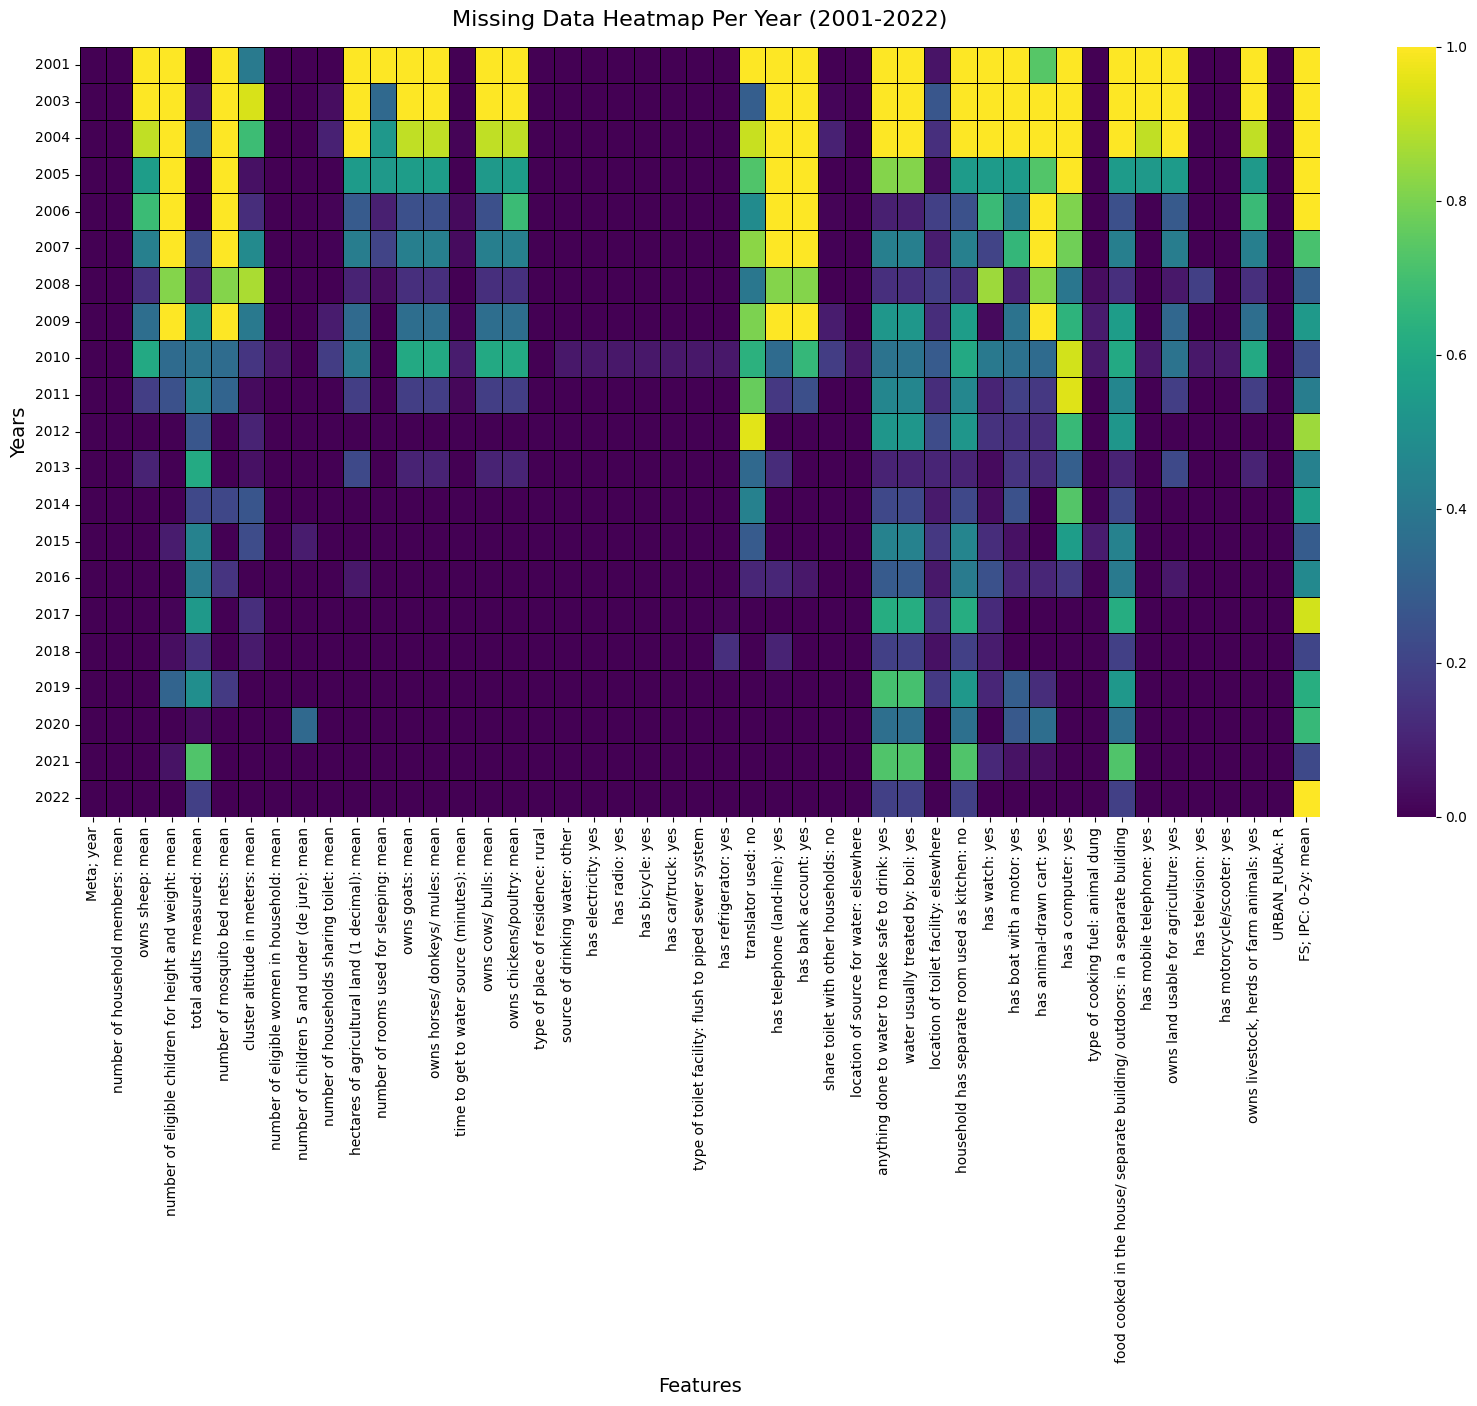

In [22]:
# removing prefixes from column names for better understanding
numerical_only.columns = numerical_only.columns.str.replace(r'^(DHS Num; |DHS Cat; )', '', regex=True)
# extracting the initial part of each column name
initial_columns = numerical_only.columns.str.extract(r'(^[^:]+)', expand=False)

# a mask to keep only the first occurrence of each initial part
unique_columns_mask = ~initial_columns.duplicated()

# the mask to keep only unique initial columns
unique_df = numerical_only.loc[:, unique_columns_mask]

# filtering the data to include only the years between 2006 and 2022
filtered_df = unique_df[(unique_df['Meta; year'] >= 2001) & (unique_df['Meta; year'] <= 2022)]

# calculating the proportion of missing data per year
missing_data_yr = filtered_df.groupby('Meta; year').apply(lambda x: x.isnull().mean())

# plotting the heatmap
plt.figure(figsize=(20, 10))
sns.heatmap(missing_data_yr, cbar=True, cmap='viridis', yticklabels=True, linecolor='black', linewidths=0.5)
plt.xlabel('Features', fontsize=14, labelpad=10)
plt.ylabel('Years', fontsize=14)
plt.title('Missing Data Heatmap Per Year (2001-2022)', fontsize=16, pad=15)
plt.xticks(rotation=90)
plt.yticks(rotation=0)

# saving the plot 
# get current working directory
current_dir = os.getcwd()
# defining output path in current directory
output_path = os.path.join(current_dir, "heatmap_per_year_missing_data.png")
# saving and showing the plot
plt.savefig(output_path, dpi=300)
plt.show()

## Pattern of Missing Data in DHS Dataset

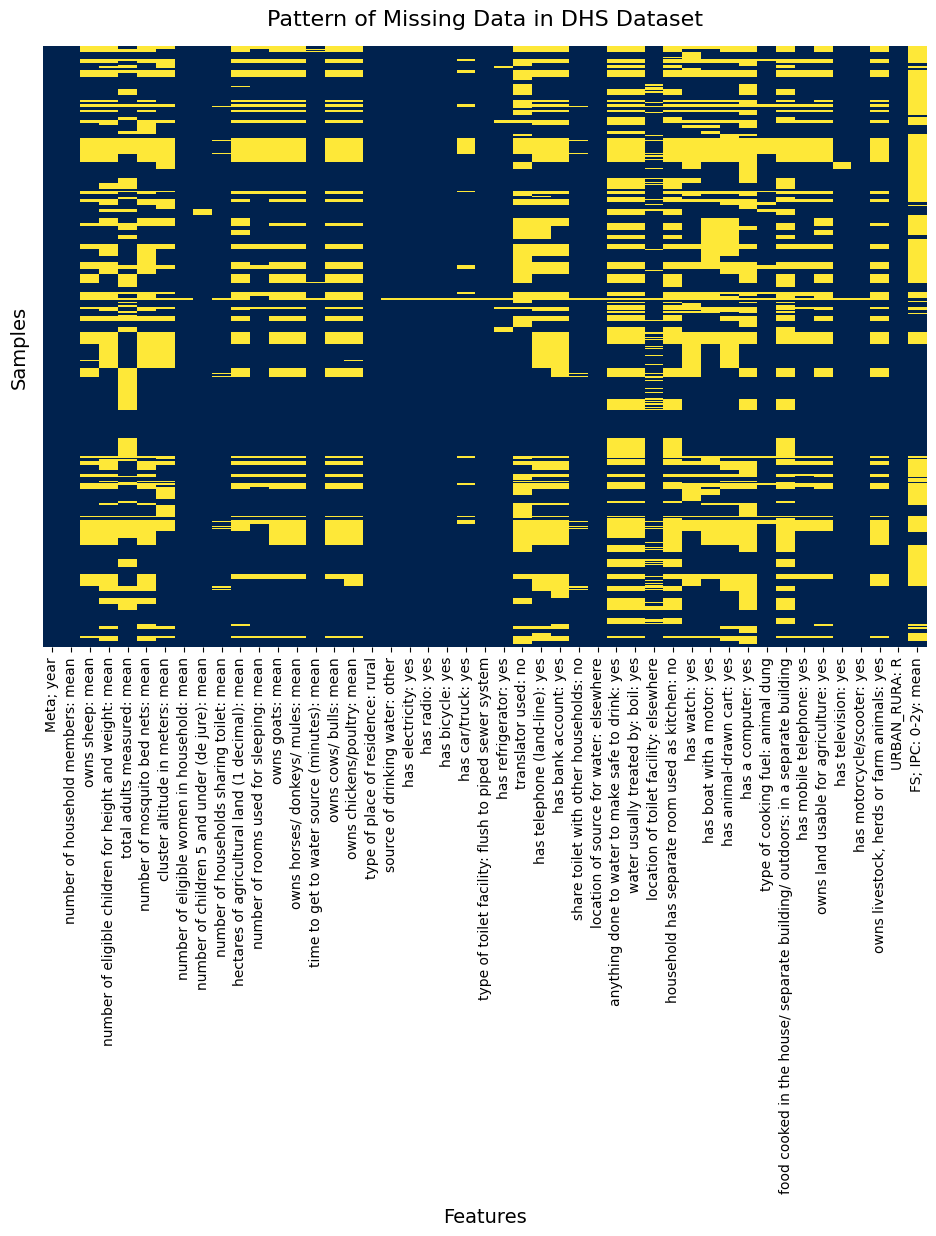

In [23]:
# setting up a larger figure with a custom color palette and aesthetic adjustments
plt.figure(figsize=(10, 13))  # adjusting size as needed for clarity

# customizing colors and add colorbar with label directly in sns.heatmap
sns.heatmap(
    unique_df.isnull(),
    cbar=False,
    cmap="cividis",
    yticklabels=False,  # removing row labels (sample numbers)
    # cbar_kws={'label': 'Missing Data (Yellow) / Complete Data (Blue)'}  # Add colorbar label here
)

# enhancing plot title, labels and colorbar for a professional presentation
plt.title("Pattern of Missing Data in DHS Dataset", fontsize=16, pad=15)
plt.xlabel("Features", fontsize=14, labelpad=10)
plt.ylabel("Samples", fontsize=14, labelpad=10)

# customized the tick parameters for readability
plt.xticks(rotation=90)
plt.yticks(rotation=0)

# showing and saving the plot
plt.tight_layout(pad=3.0)  # ensures the plot fits well without clipping
output_path = os.path.join(current_dir, "all_rows_final_missing_data_pattern.png")
plt.savefig(output_path, dpi=300)  # high resolution for publication
plt.show()

## Correlation Matrix for cleaned numerical_only dataset

Highly correlated features (Pearson > 0.7): 0.48%
Moderately correlated features (Pearson 0.3 - 0.7): 7.98%
No correlation (Pearson <= 0.3): 89.45%
Non-linear relationships (Spearman < 0.3): 87.13%
Linear relationships (Spearman >= 0.3): 12.87%


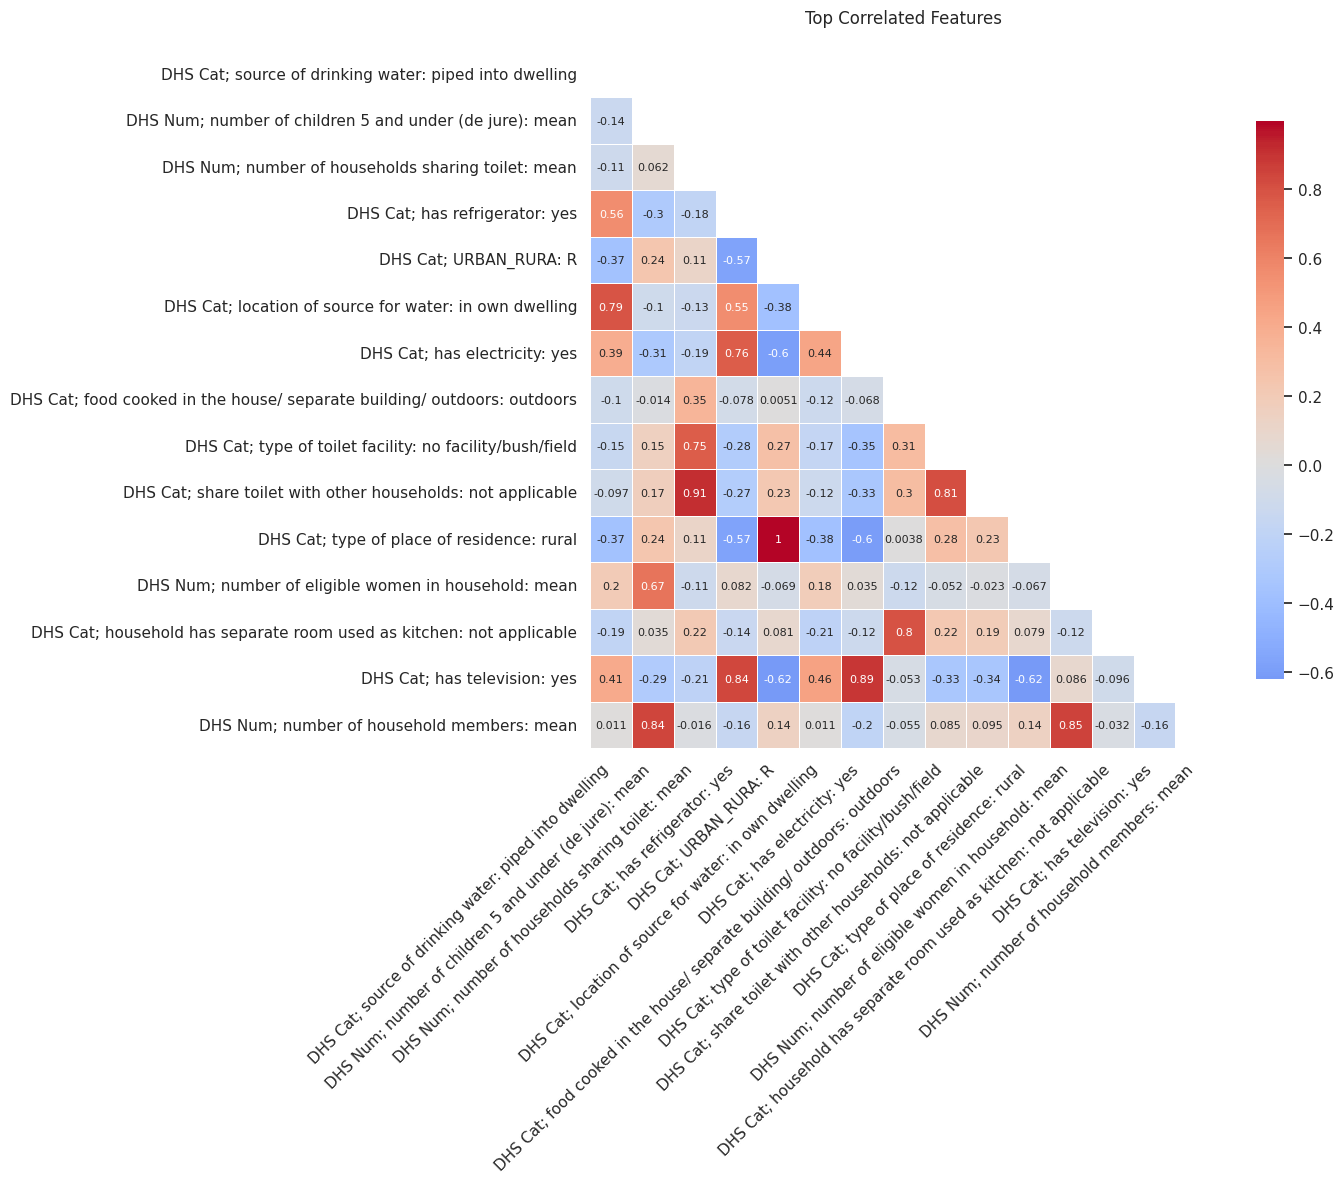

In [24]:
# thresholds for correlation categories
high_corr_threshold = 0.7
moderate_corr_threshold = 0.3

# Pearson and Spearman correlations
pearson_corr_matrix = df1_imputed.corr()
spearman_corr_matrix = df1_imputed.corr(method='spearman')

# flattening the matrices to prepare for analysis 
pearson_pairs = pearson_corr_matrix.unstack().reset_index()
spearman_pairs = spearman_corr_matrix.unstack().reset_index()
pearson_pairs.columns = ["Feature_X", "Feature_Y", "Pearson_Correlation"]
spearman_pairs.columns = ["Feature_X", "Feature_Y", "Spearman_Correlation"]

# merging Pearson and Spearman correlations into one df
correlation_df = pd.merge(pearson_pairs, spearman_pairs, on=["Feature_X", "Feature_Y"])

# exclude self-correlations
correlation_df = correlation_df[correlation_df["Feature_X"] != correlation_df["Feature_Y"]]

# categorize correlations by strength
total_pairs = len(correlation_df)
high_corr_count = len(correlation_df[correlation_df["Pearson_Correlation"].abs() > high_corr_threshold])
moderate_corr_count = len(correlation_df[(correlation_df["Pearson_Correlation"].abs() <= high_corr_threshold) & 
                                         (correlation_df["Pearson_Correlation"].abs() > moderate_corr_threshold)])
no_corr_count = len(correlation_df[correlation_df["Pearson_Correlation"].abs() <= moderate_corr_threshold])

# calculating percentages for linear relationships
high_corr_percentage = (high_corr_count / total_pairs) * 100
moderate_corr_percentage = (moderate_corr_count / total_pairs) * 100
no_corr_percentage = (no_corr_count / total_pairs) * 100

# calculating percentages for non-linear relationships using Spearman correlations
non_linear_count = len(correlation_df[correlation_df["Spearman_Correlation"].abs() < moderate_corr_threshold])
linear_count = total_pairs - non_linear_count
non_linear_percentage = (non_linear_count / total_pairs) * 100
linear_percentage = (linear_count / total_pairs) * 100

# printing the results
print(f"Highly correlated features (Pearson > {high_corr_threshold}): {high_corr_percentage:.2f}%")
print(f"Moderately correlated features (Pearson {moderate_corr_threshold} - {high_corr_threshold}): {moderate_corr_percentage:.2f}%")
print(f"No correlation (Pearson <= {moderate_corr_threshold}): {no_corr_percentage:.2f}%")
print(f"Non-linear relationships (Spearman < {moderate_corr_threshold}): {non_linear_percentage:.2f}%")
print(f"Linear relationships (Spearman >= {moderate_corr_threshold}): {linear_percentage:.2f}%")

# saving correlation data to CSV in the current directory
csv_save_path = os.path.join(current_dir, "pearson_spearman_correlation_analysis.csv")
correlation_df.to_csv(csv_save_path, index=False)

# plotting the heatmap for the top 20 correlated pairs (by Pearson correlation)
top_20_corr_pairs = correlation_df.nlargest(20, "Pearson_Correlation", keep='all')[["Feature_X", "Feature_Y"]]
top_features = list(set(top_20_corr_pairs["Feature_X"]).union(set(top_20_corr_pairs["Feature_Y"])))
top_corr_matrix = pearson_corr_matrix.loc[top_features, top_features]

# masking the upper triangle
mask = np.triu(np.ones_like(top_corr_matrix, dtype=bool))

# removing gridlines and plot the heatmap
plt.figure(figsize=(14, 12))
sns.set(style="white")
sns.heatmap(top_corr_matrix, mask=mask, annot=True, cmap='coolwarm', center=0, annot_kws={"size": 8}, 
            linewidths=.5, cbar_kws={"shrink": 0.8})
plt.title('Top Correlated Features', pad=20)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()

# saving the heatmap in the current directory
save_path = os.path.join(current_dir, "corr_matrix_original_numerical_only_dataset.png")
plt.savefig(save_path, bbox_inches='tight')
plt.show()

## numerical_only dataset being high-dimensional, a breakdown of the relationship among columns is necessary

In [25]:
# # classify relationship complexity based on Pearson and Spearman correlations
# def classify_relationship(row):
#     if abs(row['Pearson_Correlation']) > high_corr_threshold and abs(row['Spearman_Correlation']) > high_corr_threshold:
#         return 'Linear Relationship'
#     elif abs(row['Pearson_Correlation']) < moderate_corr_threshold and abs(row['Spearman_Correlation']) < moderate_corr_threshold:
#         return 'Complex Non-linear Relationship'
#     elif abs(row['Pearson_Correlation']) < high_corr_threshold and abs(row['Spearman_Correlation']) > moderate_corr_threshold:
#         return 'Simple Non-linear Relationship'
#     else:
#         return 'Uncertain Relationship'

# # applying the function and add the classification to the DataFrame
# correlation_df['Relationship_Type'] = correlation_df.apply(classify_relationship, axis=1)

# # summarizing the classification counts
# classification_counts = correlation_df['Relationship_Type'].value_counts(normalize=True) * 100

# # the classification breakdown
# print("Relationship complexity breakdown:")
# for relationship_type, percentage in classification_counts.items():
#     print(f"{relationship_type}: {percentage:.2f}%")

## non-linear relationships within Features

/tmp/ipykernel_1635876/1389017667.py:11: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spearman_corr, _ = spearmanr(df1_imputed[col1], df1_imputed[col2])


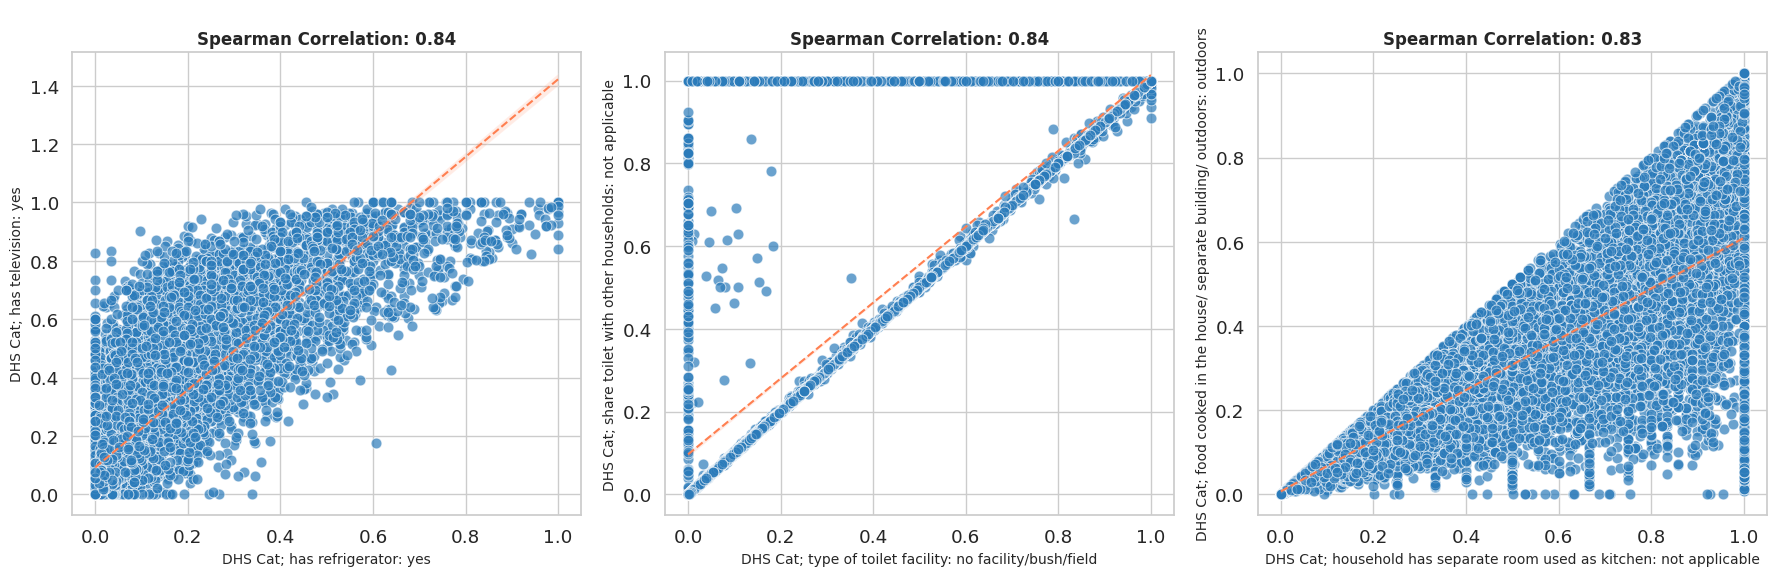

In [26]:
# seaborn style and use a built-in palette
sns.set(style="whitegrid", font_scale=1.2)
palette = sns.color_palette("Blues", n_colors=6)
selected_color = palette[4]  # Fifth color from the "Blues" palette

# list to store Spearman correlation results for all column pairs
correlation_results = []

# spearman correlation for all pairs, excluding self-correlations (correlation = 1)
for col1, col2 in itertools.combinations(df1_imputed.columns, 2):
    spearman_corr, _ = spearmanr(df1_imputed[col1], df1_imputed[col2])
    if abs(spearman_corr) < 0.85:  # Exclude perfect correlations
        correlation_results.append([col1, col2, spearman_corr])

# df from correlation results
correlation_df = pd.DataFrame(correlation_results, columns=["Feature_X", "Feature_Y", "Spearman_Correlation"])

# converting 'Spearman_Correlation' column to numeric
correlation_df["Spearman_Correlation"] = pd.to_numeric(correlation_df["Spearman_Correlation"])

# the top 3 pairs with the highest absolute Spearman correlation values
top_three_corr = correlation_df.nlargest(3, 'Spearman_Correlation', keep='all')

# a figure with 1 row and 3 columns for the plots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# iterating over the top pairs and plot each in a separate subplot
for i, row in enumerate(top_three_corr.itertuples()):
    col1, col2, spearman_corr = row.Feature_X, row.Feature_Y, row.Spearman_Correlation

    # plotting non-linear relationship visualization with selected color and coral for regression line
    sns.scatterplot(
        data=df1_imputed, x=col1, y=col2,
        color=selected_color, alpha=0.7, s=60, ax=axes[i]
    )

    # adding regression line with confidence interval
    sns.regplot(
        data=df1_imputed, x=col1, y=col2,
        scatter=False, ax=axes[i],
        color="coral", ci=95, line_kws={"linewidth": 1.5, "linestyle": "--"}
    )

    # customized the title and labels
    axes[i].set_title(f"\nSpearman Correlation: {spearman_corr:.2f}", fontsize=12, weight="bold")
    axes[i].set_xlabel(col1, fontsize=10)
    axes[i].set_ylabel(col2, fontsize=10)

# current working directory for saving files
plot_path = os.path.join(current_dir, "nonlinear_scatter_plots.png")
csv_path = os.path.join(current_dir, "top_three_spearman_correlation_results.csv")

# adjusting layout for clear display and saving the plot
plt.tight_layout()
plt.savefig(plot_path)
plt.show()

# saving correlation results to CSV
correlation_df.to_csv(csv_path, index=False)

In [27]:
# correlation_results = []

# # calculating Spearman correlation for all pairs, excluding self-correlations (correlation = 1)
# for col1, col2 in itertools.combinations(df1_imputed.columns, 2):
#     spearman_corr, _ = spearmanr(df1_imputed[col1], df1_imputed[col2])
#     correlation_results.append([col1, col2, spearman_corr])

# # creating df from correlation results
# correlation_df = pd.DataFrame(correlation_results, columns=["Feature_X", "Feature_Y", "Spearman_Correlation"])

# # determining linear and non-linear correlations based on threshold
# linear_threshold = 0.3
# non_linear_count = correlation_df[correlation_df["Spearman_Correlation"].abs() < linear_threshold].shape[0]
# linear_count = correlation_df[correlation_df["Spearman_Correlation"].abs() >= linear_threshold].shape[0]
# total_count = non_linear_count + linear_count

# # calculating and print percentages
# non_linear_percentage = (non_linear_count / total_count) * 100
# linear_percentage = (linear_count / total_count) * 100
# print(f"Non-linear percentage: {non_linear_percentage:.2f}%")
# print(f"Linear percentage: {linear_percentage:.2f}%")

# Finding feature importance 

### Principal Component Analysis (PCA) with Barplot

In [28]:
# actual values where there is no missing values
df1 = df1_imputed.copy()

# scaling the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df1)
df1_scaled = pd.DataFrame(scaled_data, columns=df1.columns)

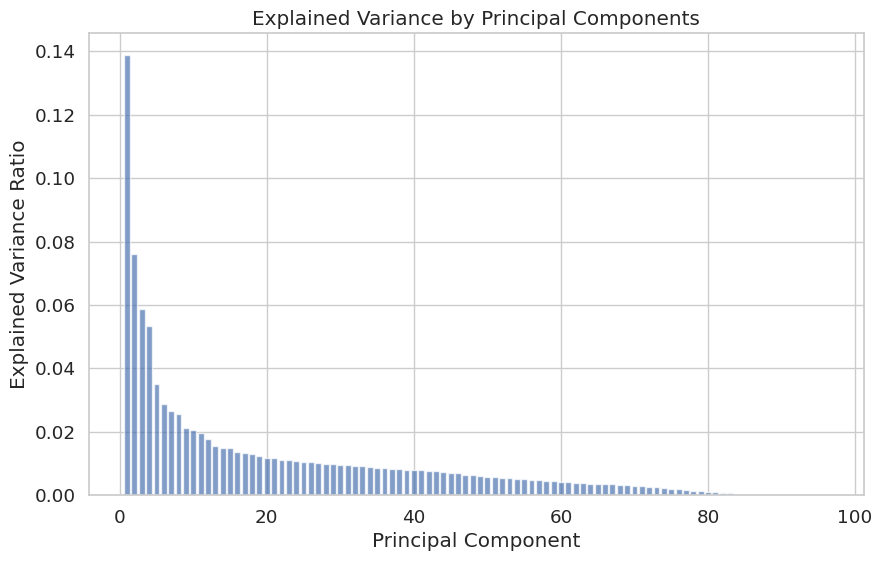

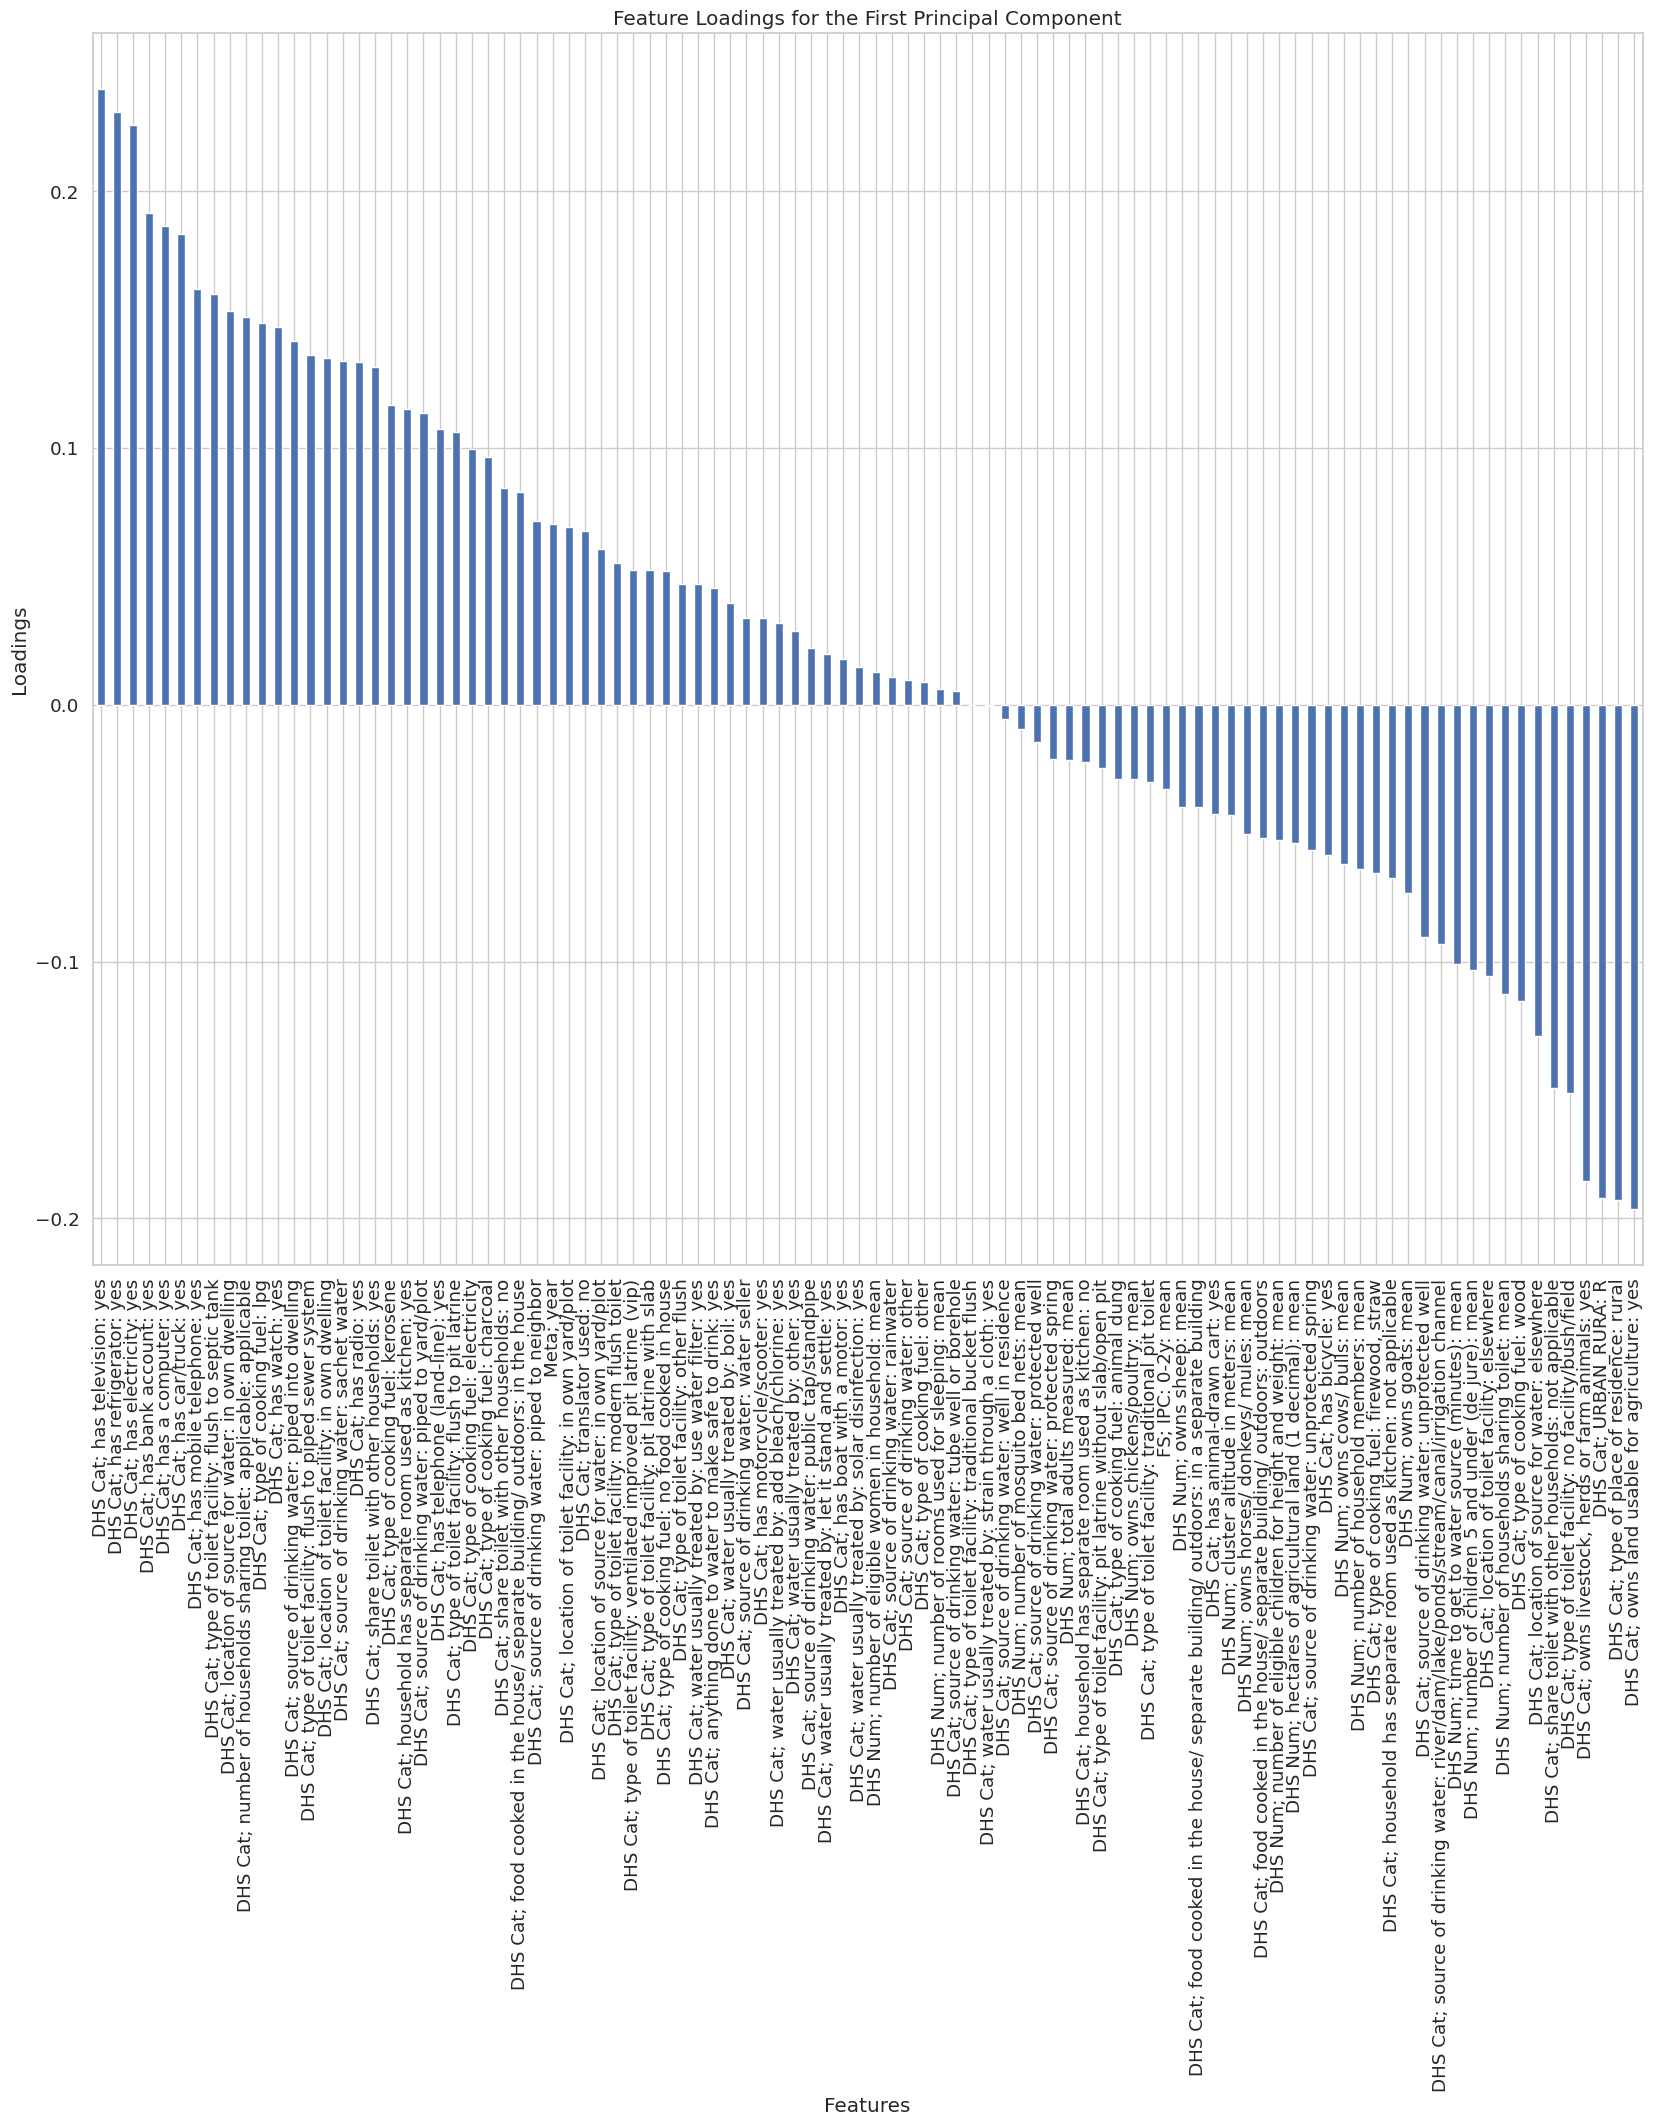

In [29]:
# performing PCA
pca = PCA()
pca.fit(df1_scaled)

#the explained variance ratio for each component
explained_variance = pca.explained_variance_ratio_

#the loadings (feature importance in each principal component)
loadings = pd.DataFrame(pca.components_.T, columns=[f'PC{i+1}' for i in range(df1_scaled.shape[1])], index=df1_scaled.columns)

#explained variance
# print('Explained variance ratio for each component:')
# print(explained_variance)

#displaying loadings
# print('Feature loadings for each principal component:')
# print(loadings)

#the explained variance
plt.figure(figsize=(10, 6))
plt.bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.7)
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance by Principal Components')
plt.show()

#the loadings of the first principal component
plt.figure(figsize=(20, 16))
loadings['PC1'].sort_values(ascending=False).plot(kind='bar')
plt.xlabel('Features')
plt.ylabel('Loadings')
plt.title('Feature Loadings for the First Principal Component')
plt.show()

## Explained Variance by Principal Components:

- What is plotted: A bar plot showing the explained variance ratio for each principal component.
- What the values refer to: Each bar represents the proportion of the dataset's total variance that is explained by a principal component. The height of each bar indicates how much variance is captured by each principal component. For instance, if the first principal component explains 40% of the variance, its bar will reach up to 0.4 on the y-axis.
- X-axis: Principal components (PC1, PC2, etc.).
Y-axis: Explained variance ratio (a value between 0 and 1).
This plot helps to understand how much of the total variance in the dataset is captured by each principal component. It is useful for determining the number of principal components to keep for further analysis.

## Feature Loadings for the First Principal Component:

- What is plotted: A bar plot showing the loadings of features on the first principal component.
- What the values refer to: The loadings (coefficients) indicate the contribution of each feature to the first principal component. The bars show the magnitude and direction (positive or negative) of each feature's contribution. A higher absolute value of loading means that the feature contributes more to that principal component.

- X-axis: Feature names.
Y-axis: Loadings (coefficients).
This plot shows which features contribute the most to the first principal component. Features with higher absolute loadings have a more significant impact on the principal component. Positive and negative loadings indicate the direction of the contribution.

## Example Interpretation
If the first principal component explains 30% of the variance (explained variance ratio of 0.3), it means this single component captures 30% of the total variability in your data.
If a feature has a loading of 0.8 in the first principal component, it has a strong positive influence on that component. Conversely, if another feature has a loading of -0.6, it has a strong negative influence.
These plots help in understanding both the significance of the principal components and the contribution of each feature to these components, aiding in feature importance analysis in the absence of a target variable.

/home/myuser/.local/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


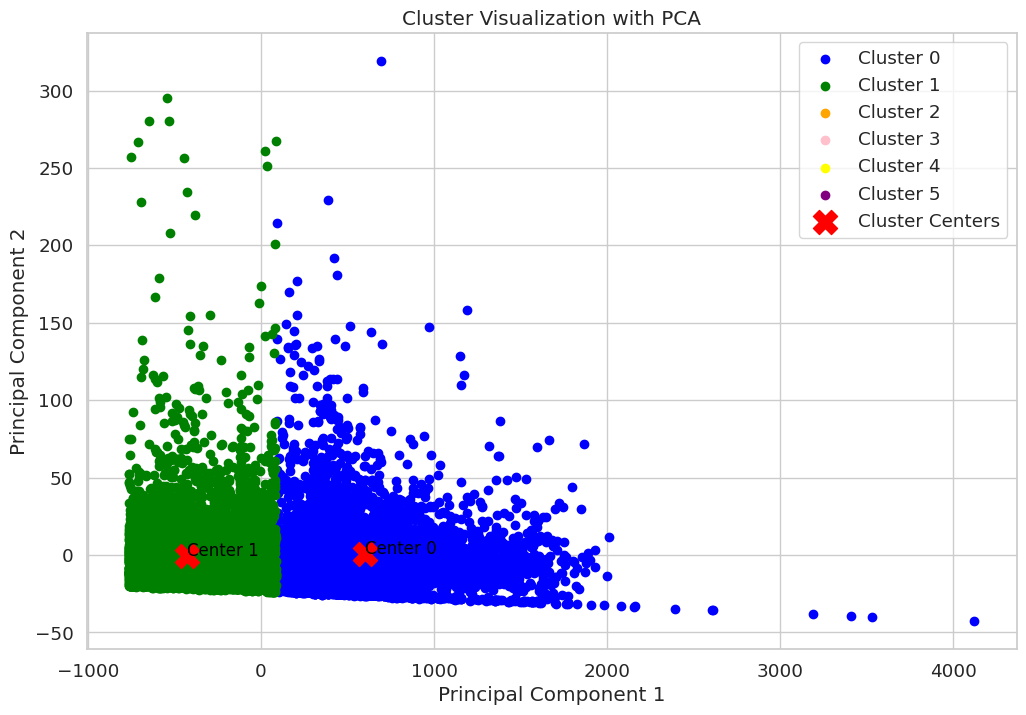

In [34]:
# k-Means clustering
kmeans = KMeans(n_clusters=2, random_state=42)
clusters = kmeans.fit_predict(df1_imputed)

#cluster labels to the DataFrame
df1_imputed['Cluster'] = clusters

#PCA to reduce dimensionality for visualization
pca = PCA(n_components=55)
reduced_data = pca.fit_transform(df1_imputed)

#the clustered data
plt.figure(figsize=(12, 8))
colors = ['blue', 'green', 'orange', 'pink', 'yellow', 'purple']
for i in range(6):
    plt.scatter(reduced_data[clusters == i, 0], reduced_data[clusters == i, 1], 
                color=colors[i], label=f'Cluster {i}', marker='o')
#cluster centers
cluster_centers = kmeans.cluster_centers_
reduced_cluster_centers = pca.transform(cluster_centers)
plt.scatter(reduced_cluster_centers[:, 0], reduced_cluster_centers[:, 1], 
            s=300, c='red', marker='X', label='Cluster Centers')

#annotations for cluster centers
for i, txt in enumerate(reduced_cluster_centers):
    plt.annotate(f'Center {i}', (reduced_cluster_centers[i, 0], reduced_cluster_centers[i, 1]), 
                 fontsize=12, color='black')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Cluster Visualization with PCA')
plt.legend(loc='best')
plt.grid(True)
plt.show()

In the provided code, k-means clustering and PCA (Principal Component Analysis) are used together to perform clustering on high-dimensional data and to visualize the results in a lower-dimensional space. Here’s how they work together:

k-Means Clustering: The k-means algorithm is applied to the original high-dimensional data to partition the data into clusters.
Each data point is assigned a cluster label based on the cluster it belongs to.
PCA for Dimensionality Reduction:

PCA is applied to the high-dimensional data (excluding the cluster labels) to reduce its dimensionality to 2 components.
This allows for visualizing the data in a 2-dimensional space while preserving as much variance as possible from the original data.

Visualization: The data points are plotted in the reduced 2-dimensional space with different colors representing different clusters.
The cluster centers, which are computed in the original high-dimensional space, are transformed to the reduced 2-dimensional space using the same PCA transformation.
The transformed cluster centers are then plotted as red 'X' markers.